In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import squidpy as sq
import numpy as np

from PIL import Image
import networkx as nx
import matplotlib.cm as cmx
import matplotlib.colors as colors

import ncem

usr = !echo $USER
base_path = '.'
base_path_out = '.'

grid_search_dir = '.'
datadir = '.'
targetpath = '.'
configpath = '.'
outdir = base_path_out + '/results/'
figdir = outdir+'/figures/'

sc.logging.print_version_and_date()
sc.settings.verbosity = 0
sc.settings.figdir = figdir


# remove later
dir_data = "/storage/groups/ml01/workspace/anna.schaar/tissue/data/"

Running Scanpy 1.7.2, on 2021-06-25 14:33.


# MERFISH - brain

In [2]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_path=dir_data + 'zhang/',
    data_origin="zhang",
    radius=100,
    node_label_space_id='type',
    node_feature_space_id='standard'
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata


/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


collecting image-wise celldata


  5%|▍         | 3/64 [00:00<00:02, 22.64it/s]

adding graph-level covariates


100%|██████████| 64/64 [00:03<00:00, 19.37it/s]


Loaded 64 images with complete data from 2 patients over 280327 cells with 254 cell features and 25 distinct celltypes.
Mean of mean node degree per images across images: 40.670611

 Celldata metadata: {'lateral_resolution': 0.109, 'fn': 'preprocessed_zhang.h5ad', 'image_col': 'slice_id', 'pos_cols': ['center_x', 'center_y'], 'cluster_col': 'subclass', 'cluster_col_preprocessed': 'subclass_preprocessed', 'patient_col': 'mouse'}


100%|██████████| 64/64 [05:33<00:00,  5.20s/it]


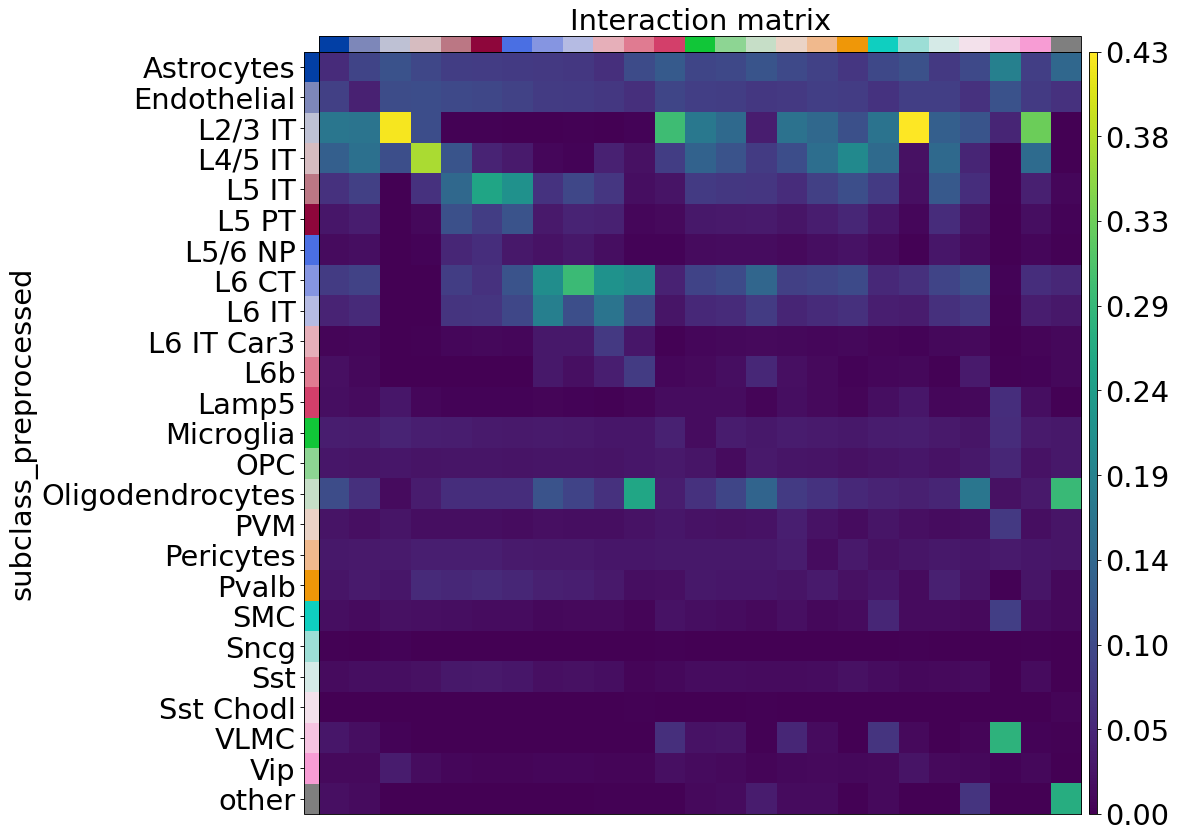

In [4]:
interpreter.data.celldata_interaction_matrix(
    figsize=(10,10),
    fontsize=26
)

  0%|          | 0/64 [00:00<?, ?it/s]/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/squidpy/gr/_nhood.py:180: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)
 17%|█▋        | 11/64 [00:15<00:48,  1.10it/s]/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/squidpy/gr/_nhood.py:180: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)
 53%|█████▎    | 34/64 [00:30<00:14,  2.07it/s]/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/squidpy/gr/_nhood.py:180: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)
100%|██████████| 64/64 [00:46<00:00,  1.38it/s]
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype inste

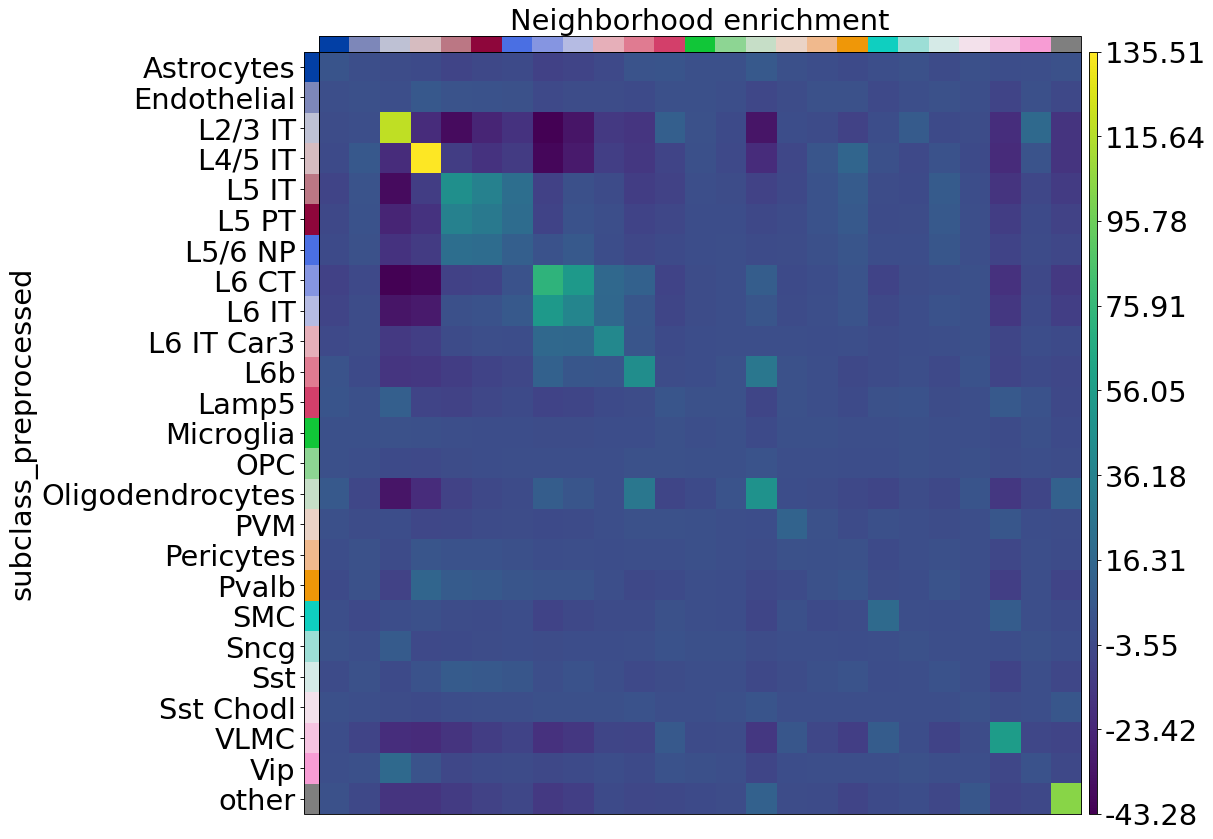

In [5]:
interpreter.data.celldata_nhood_enrichment(
    figsize=(10,10),
    fontsize=26
)

### Figure 1: Modeling cell communication as spatial cell state dependencies.
#### UMAP mouse 1 slice 153 - Fig. 1b

n cells:  7439


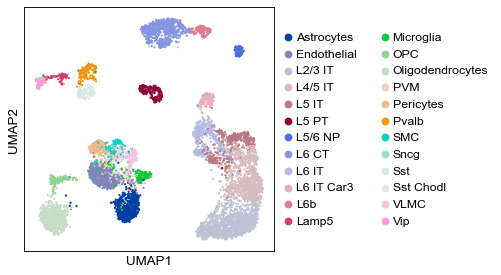

In [46]:
interpreter.data.umap(
    image_key= "mouse1_slice153",
    undefined_type='other',
    n_neighbors=10,
    n_pcs=35,
    copy=False,
    fontsize=12,
    panel_width=4,
    panel_height=4
)

Trying to set attribute `.uns` of view, copying.


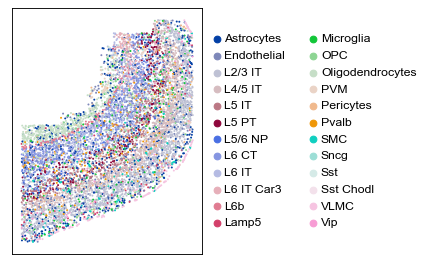

In [31]:
adata = interpreter.data.spatial(
    image_key= "mouse1_slice153",
    undefined_type='other',
    panel_width=5,
    panel_height=5,
    fontsize=12,
    clean_view=True,
    copy=True
)

#### Example image 488 of mouse 1 slice 153 (dataset 1 sample 3) - Fig. 1b

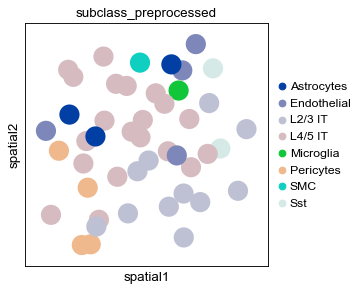

In [33]:
dataset1_sample3_486 = adata[adata.obs['fovID'] == 486]
# for hte MERFISH brain datase, coordinates are given as µm, which is transformed to pixels to match the image
dataset1_sample3_486.obsm['spatial'] = dataset1_sample3_486.obsm['spatial']/interpreter.data.celldata.uns['metadata']['lateral_resolution']
sc.pl.spatial(
    dataset1_sample3_486, 
    spot_size=200, 
    color='subclass_preprocessed', 
)

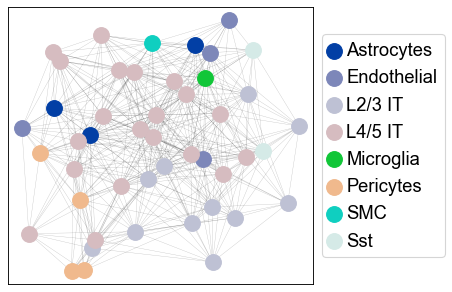

In [35]:
panel_width = 6.
panel_height = 4.
edge_width = 0.3

sc.set_figure_params(scanpy=True, fontsize=18)
plt.rcParams["axes.grid"] = False

h_0 = dataset1_sample3_486.obsm["node_types"]
a = dataset1_sample3_486.obsp["adjacency_matrix_connectivities"]
cell_types = dataset1_sample3_486.obs["subclass_preprocessed"]
if cell_types is None:
    raise ValueError('No cell types for this image available')
# Mask cell types like data batch:
cell_types = cell_types[np.arange(0, a.shape[0])]

cell_type_names = dataset1_sample3_486.uns['node_type_names']

g = nx.from_numpy_matrix(a.todense())
# Include masking of data batch by using h shape:
dict_nodes = {i: np.array(dataset1_sample3_486.obsm["spatial"])[i] for i in np.arange(h_0.shape[0])}

fig = plt.figure(figsize=(panel_width, panel_height))
ax = fig.add_subplot(111)
nx.draw_networkx_edges(
    g,
    pos=dict_nodes,
    width=edge_width,
    alpha=0.25
)

for i, ctype in enumerate(np.unique(cell_types)):
    # print(ctype)
    #color = [zeileis_28[cell_type_names[ctype]]]
    idx_c = list(np.where(cell_types == ctype)[0])
    nx.draw_networkx_nodes(
        g,
        # with_labels=False,
        node_size=200,
        nodelist=idx_c,
        node_color=dataset1_sample3_486.uns['subclass_preprocessed_colors'][i],
        pos=dict_nodes,
        label=cell_type_names[ctype].replace(
            '_', ' '
        )
    )
box = ax.get_position()
ax.invert_yaxis()
ax.set_position([box.x0, box.y0, box.width, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
# plt.savefig("dataset1_sample3_488_graph_10um.pdf")

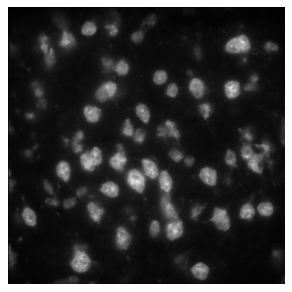

In [90]:
fn = f"{datadir}zhang/processed_images486.tif"
img = Image.open(fn)
images = []
for i in range(img.n_frames):
    img.seek(i)
    images.append(np.array(img))
img.close()

images = np.array(images)
images = np.transpose(images, (1, 2, 0))

# readoutName polyT are in frames [154:160] with zPos (µm) [0.  1.5 3.  4.5 6.  7.5 9. ]
# we show the center z-plane at z=4.5µm
img = sq.im.ImageContainer(images[:, :, 157])
sq.im.process(img)
img.show('image_smooth', cmap="Greys_r", figsize=(4,4))

### Figure 2: Attributing cell heterogeneity to niche composition.
#### UMAP of L2/3 IT sub-states in slice 153 - Fig. 2 a

n cells:  1204
L2/3 IT 0    316
L2/3 IT 1    314
L2/3 IT 2    313
L2/3 IT 3    133
L2/3 IT 4    128
Name: L2/3 IT_substates, dtype: int64


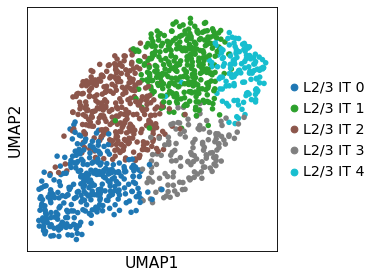

In [8]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice153",
    target_cell_type='L2/3 IT',
    n_neighbors=40,
    n_pcs=40,
    fontsize=14,
    panel_width=4,
    panel_height=4,
    palette='tab10'
)

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


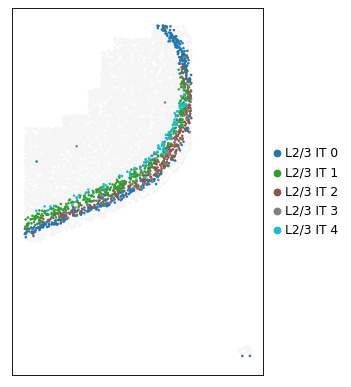

In [9]:
interpreter.data.spatial_substates(
    adata,
    image_key= "mouse1_slice153",
    target_cell_type='L2/3 IT',
    panel_width=5,
    panel_height=5,
    fontsize=12,
    #clean_view=True
)

#### UMAPs of L2/3 IT neighbourhoods in slice 153 - Fig. 1c

In [419]:
filter_titles = [
    'Oligodendrocytes',
    'Pvalb',
    'L4/5 IT',
    'Sncg',
    'Lamp5',
    'Vip',
    'L5/6 NP',
    'VLMC',
    'L6 IT Car3',
    'Microglia',
    'Endothelial',
    'L5 IT',
    'Sst',
    'OPC',
    'Astrocytes',
    'L2/3 IT',
    'Sst Chodl',
    'Pericytes',
    'SMC',
    'PVM'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key='mouse1_slice153',
    target_cell_type='L2/3 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles,
    n_neighbors=40,
    n_pcs=40
)

100%|██████████| 153/153 [01:54<00:00,  1.34it/s]


n cells:  1204
L2/3 IT 0    316
L2/3 IT 1    314
L2/3 IT 2    313
L2/3 IT 3    133
L2/3 IT 4    128
Name: L2/3 IT_substates, dtype: int64


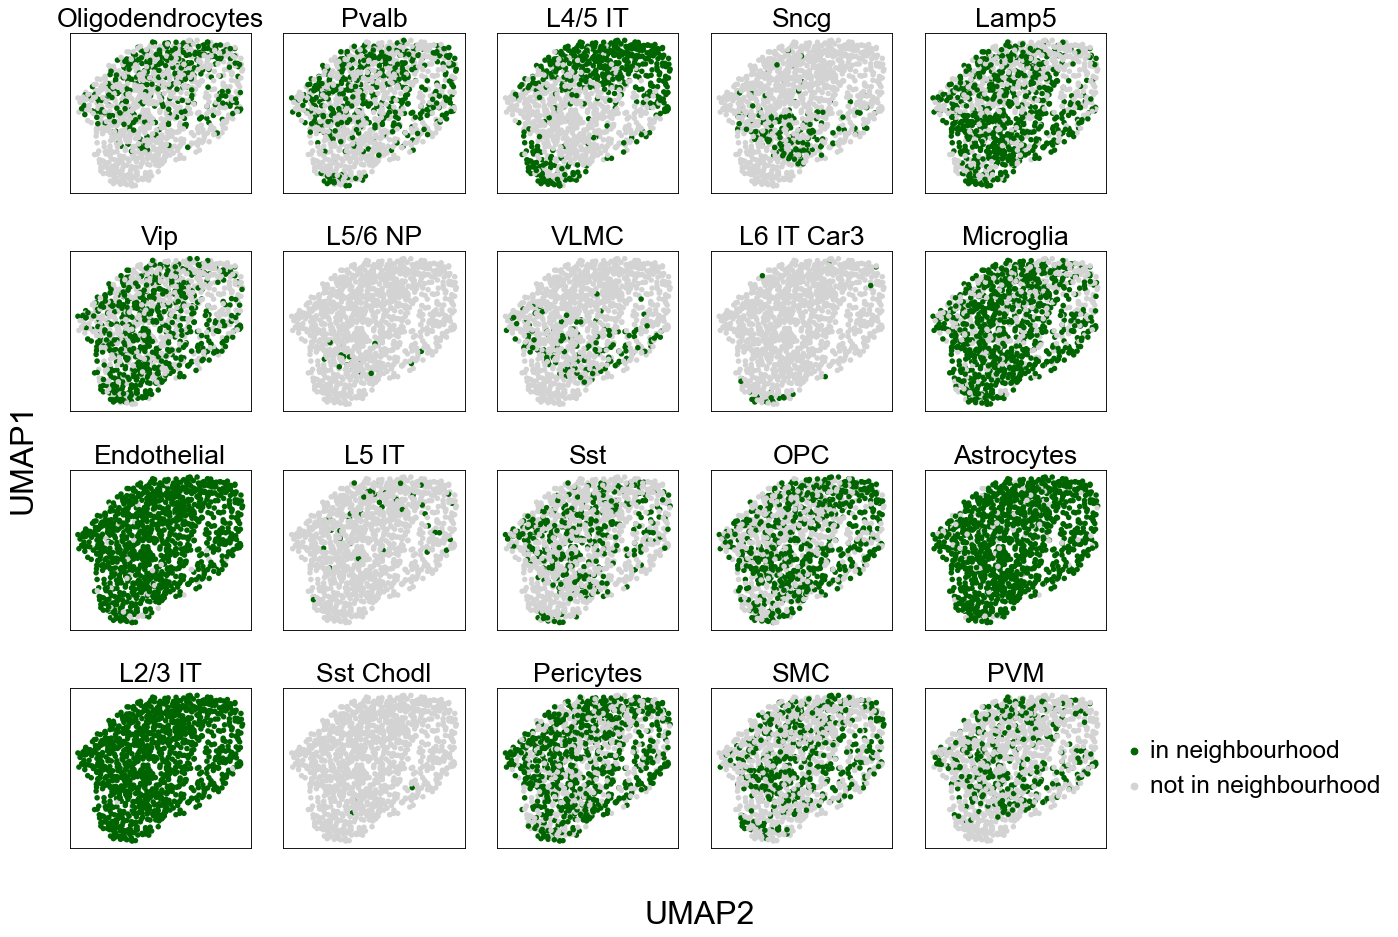

In [39]:
interpreter.data.umaps_cluster_enrichment(adata, filter_titles)

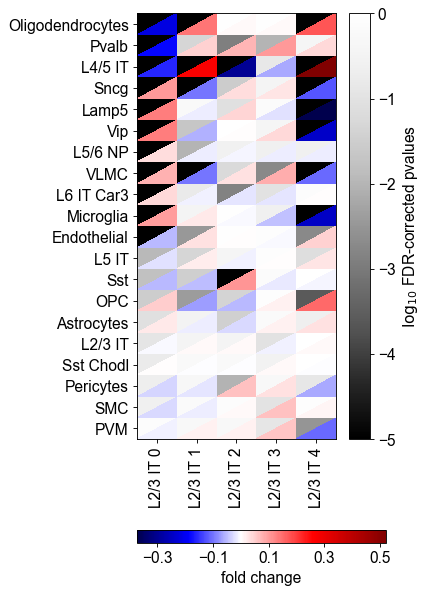

In [427]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=14,
    linspace=(-0.3, 0.5, 5)
)

### Variance decomposition - Supp. Fig. 4a

In [42]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='other')

100%|██████████| 64/64 [04:38<00:00,  4.35s/it]


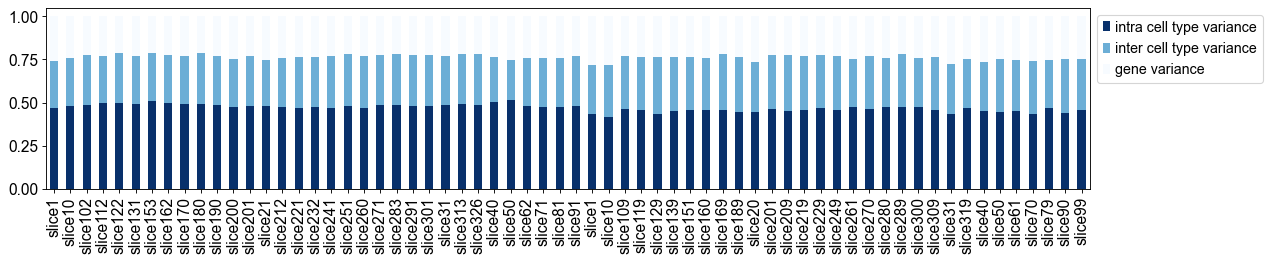

In [43]:
interpreter.data.variance_decomposition(var_decomp, multiindex=True)

### Ligand-receptor analysis - Supp. Fig. 7a-b

n cells: 27638


  0%|          | 0/1000 [00:00<?, ?permutation/s]

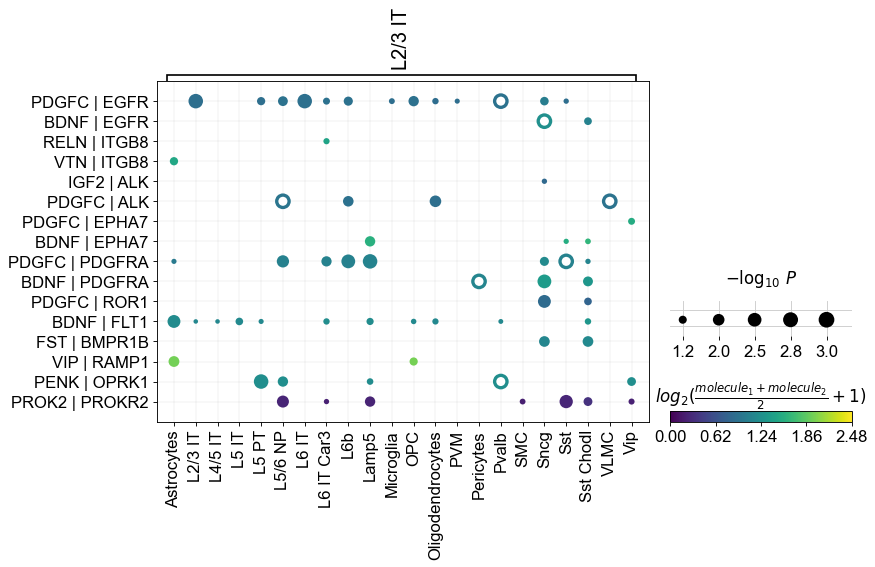

In [47]:
adata = interpreter.data.ligrec(
    fraction=0.1,
    source_groups='L2/3 IT',
    undefined_type='other',
)

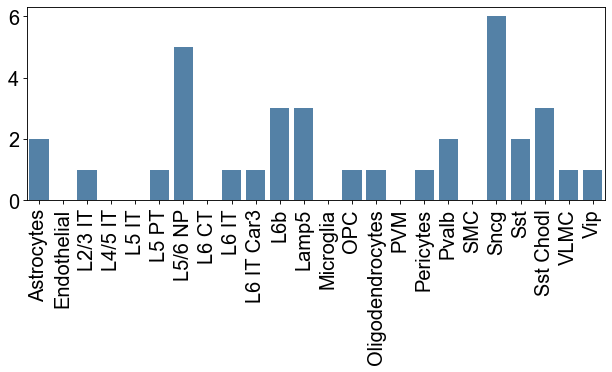

In [48]:
interpreter.data.ligrec_barplot(
    adata,
    source_group='L2/3 IT',
)

n cells: 7439


  0%|          | 0/1000 [00:00<?, ?permutation/s]

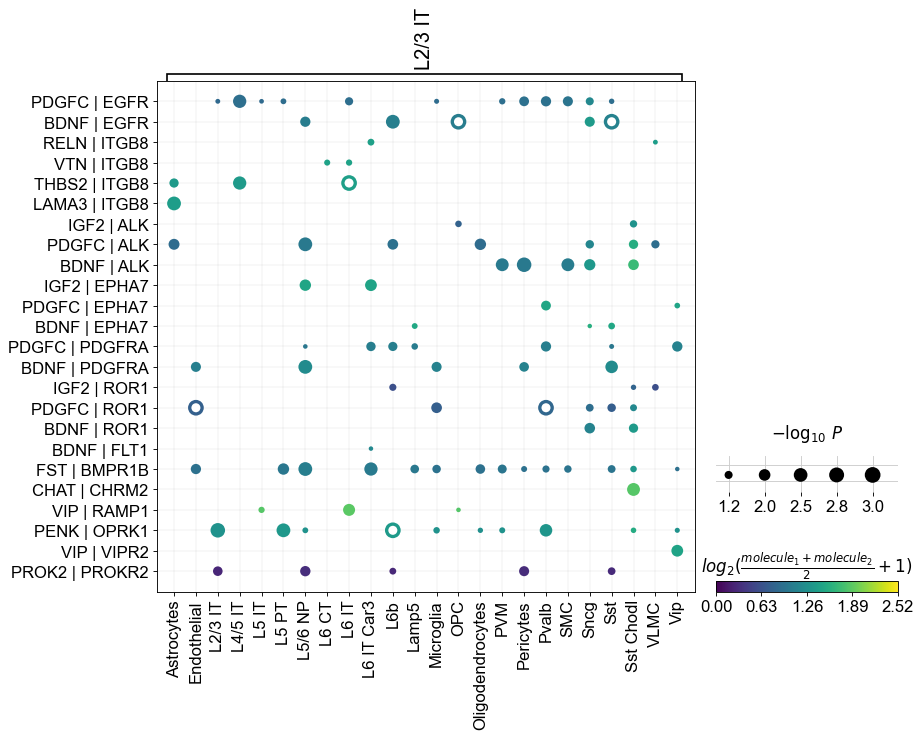

In [49]:
adata = interpreter.data.ligrec(
    image_key= "mouse1_slice153",
    source_groups='L2/3 IT',
    undefined_type='other',
)

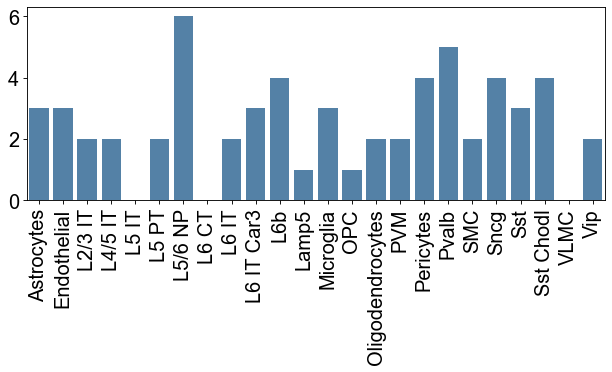

In [50]:
interpreter.data.ligrec_barplot(
    adata,
    source_group='L2/3 IT',
)

### Noise structure - Supp. Fig. 12a

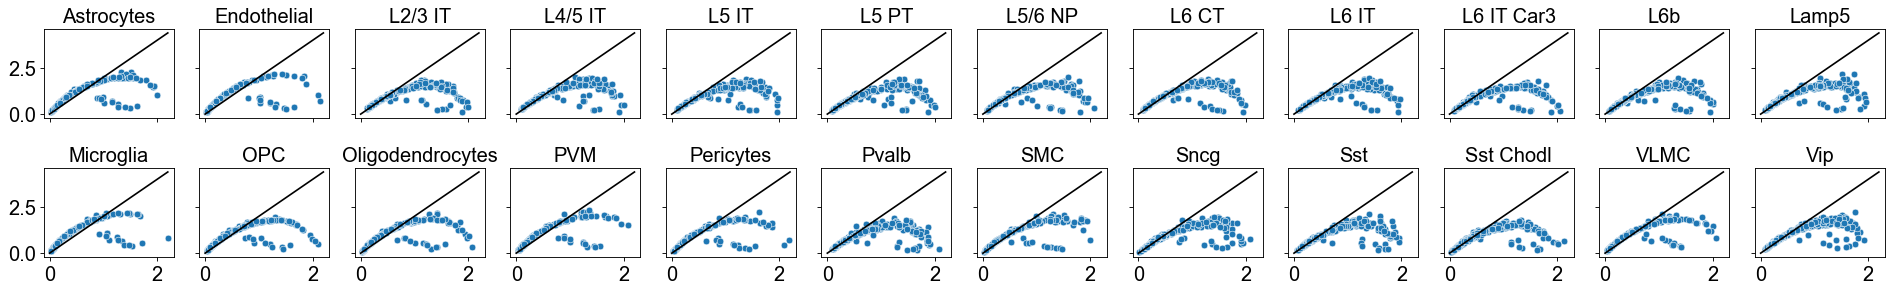

In [55]:
interpreter.data.noise_structure(undefined_type='other', min_x=0.0, max_x=2.2)

##  Replicate analysis for attribution of molecular states to neighborhoods in the MERFISH – brain data set. - Supp. Fig 5b-f

n cells:  6759


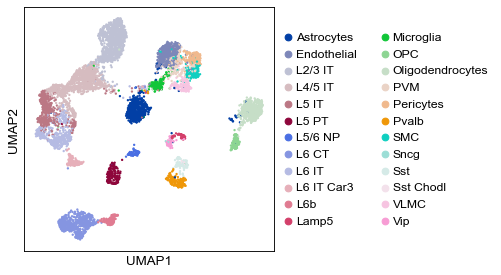

In [56]:
interpreter.data.umap(
    image_key= "mouse1_slice162",
    undefined_type='other',
    n_neighbors=10,
    n_pcs=35,
    copy=False,
    fontsize=12,
    panel_width=4,
    panel_height=4
)

Trying to set attribute `.uns` of view, copying.


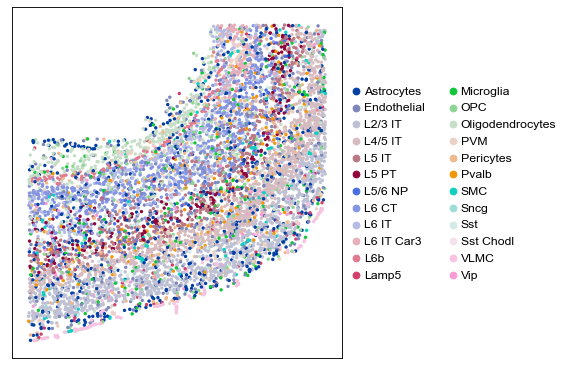

In [57]:
interpreter.data.spatial(
    image_key= "mouse1_slice162",
    undefined_type='other',
    fontsize=12,
    copy=False
)

n cells:  946
L2/3 IT 0    226
L2/3 IT 1    209
L2/3 IT 2    193
L2/3 IT 3    191
L2/3 IT 4    127
Name: L2/3 IT_substates, dtype: int64


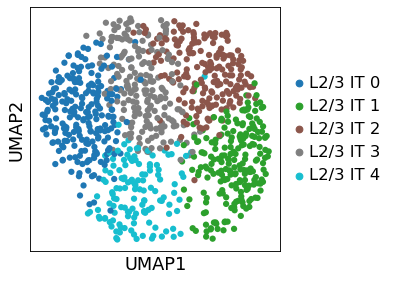

In [16]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice162",
    target_cell_type='L2/3 IT',
    n_neighbors=40,
    n_pcs=40,
    fontsize=16,
    panel_width=4,
    panel_height=4,
    palette='tab10'
)

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


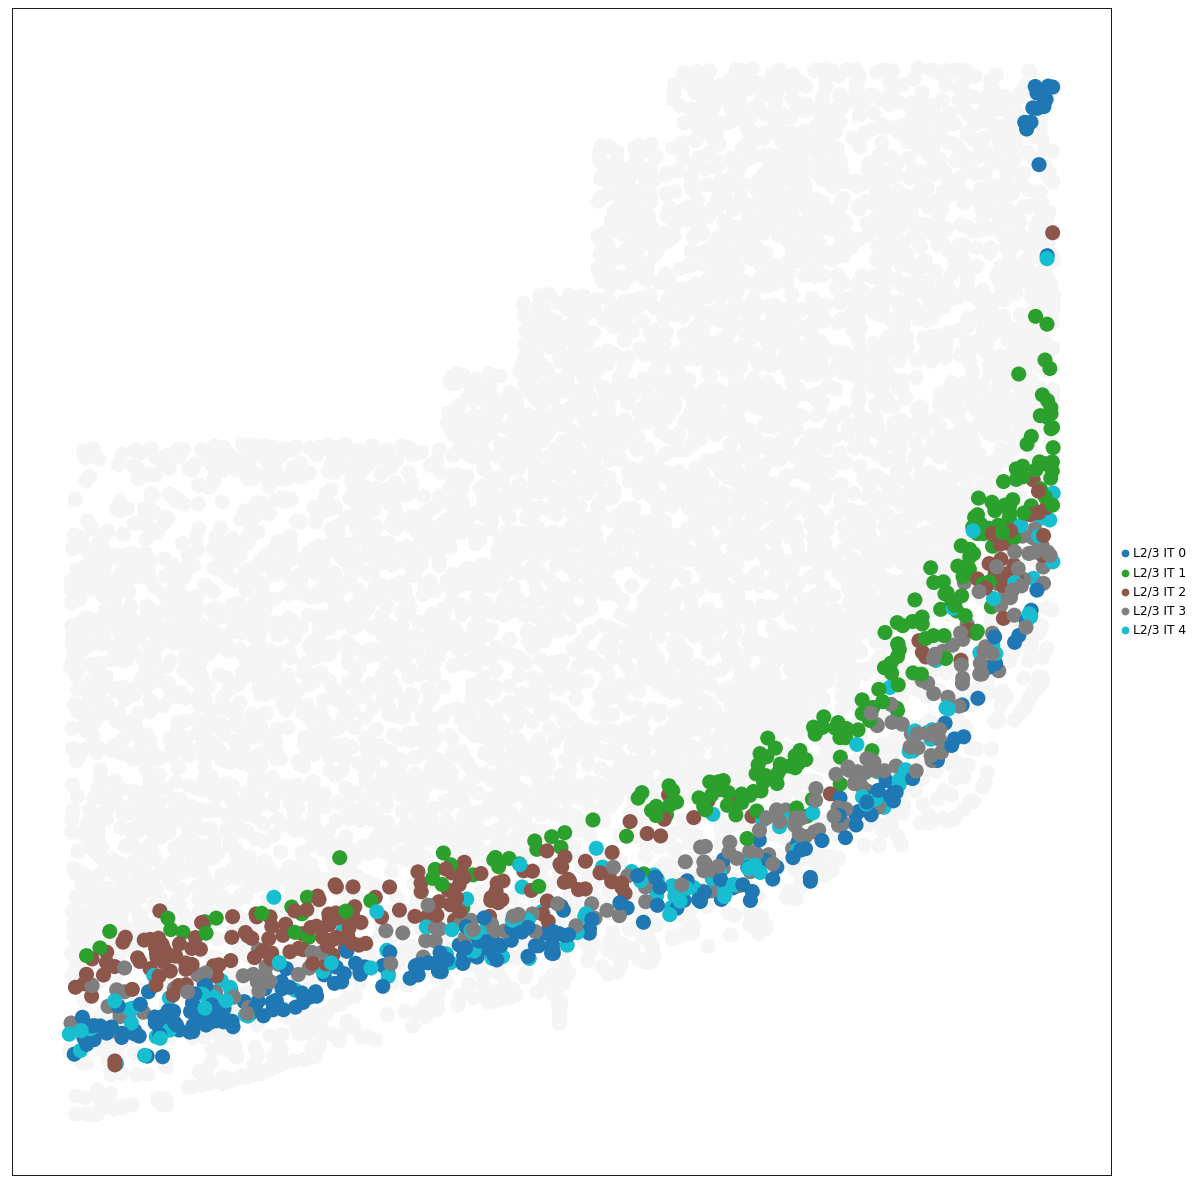

In [17]:
interpreter.data.spatial_substates(
    adata,
    image_key= "mouse1_slice162",
    target_cell_type='L2/3 IT',
    panel_width=15,
    panel_height=15,
    fontsize=12,
)

In [12]:
filter_titles = ['L4/5 IT',
 'VLMC',
 'Pvalb',
 'Sncg',
 'Sst Chodl',
 'SMC',
 'Astrocytes',
 'Lamp5',
 'PVM',
 'L5 IT',
 'Oligodendrocytes',
 'L6 IT',
 'L2/3 IT',
 'Endothelial',
 'Sst',
 'OPC',
 'L6b',
 'Vip',
 'Microglia',
 'Pericytes'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key='mouse1_slice162',
    target_cell_type='L2/3 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles
)

100%|██████████| 153/153 [01:54<00:00,  1.33it/s]


n cells:  946
L2/3 IT 0    226
L2/3 IT 1    209
L2/3 IT 2    193
L2/3 IT 3    191
L2/3 IT 4    127
Name: L2/3 IT_substates, dtype: int64


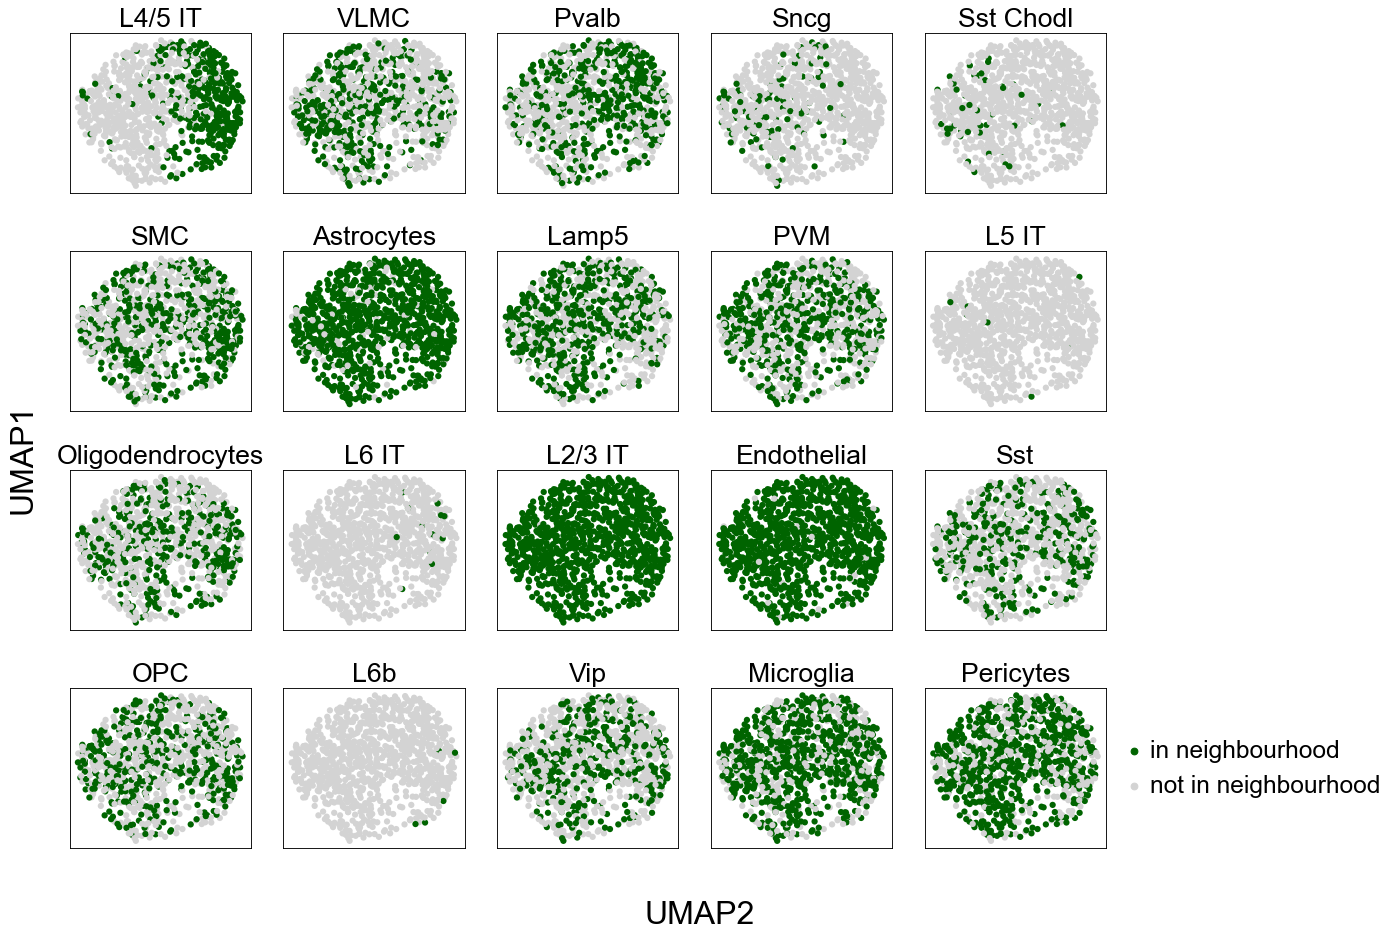

In [63]:
interpreter.data.umaps_cluster_enrichment(adata, filter_titles)

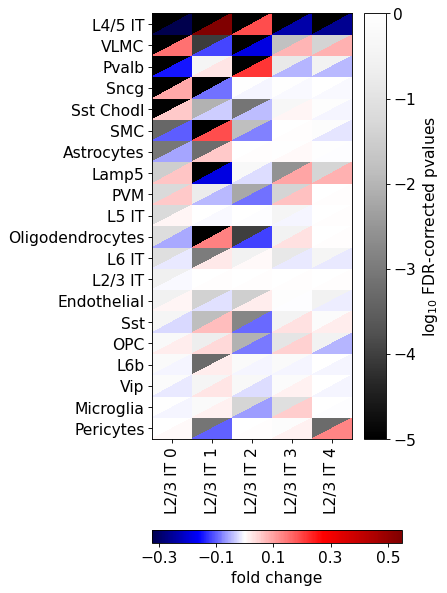

In [14]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=14,
    linspace=(-0.3, 0.5, 5)
)

In [431]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='zhang',
    data_path=datadir + 'zhang/',
    radius=6000,
    node_label_space_id='type',
    node_feature_space_id='standard'
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata
collecting image-wise celldata


  0%|          | 0/64 [00:00<?, ?it/s]

adding graph-level covariates


100%|██████████| 64/64 [03:21<00:00,  3.15s/it]


Loaded 64 images with complete data from 2 patients over 280327 cells with 254 cell features and 25 distinct celltypes.
Mean of mean node degree per images across images: 4379.109375

 Celldata metadata: {'lateral_resolution': 0.109, 'fn': 'preprocessed_zhang.h5ad', 'image_col': 'slice_id', 'pos_cols': ['center_x', 'center_y'], 'cluster_col': 'subclass', 'cluster_col_preprocessed': 'subclass_preprocessed', 'patient_col': 'mouse'}


In [432]:
filter_titles = [
    'Oligodendrocytes',
    'Pvalb',
    'L4/5 IT',
    'Sncg',
    'Lamp5',
    'Vip',
    'L5/6 NP',
    'VLMC',
    'L6 IT Car3',
    'Microglia',
    'Endothelial',
    'L5 IT',
    'Sst',
    'OPC',
    'Astrocytes',
    'L2/3 IT',
    'Sst Chodl',
    'Pericytes',
    'SMC',
    'PVM'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key='mouse1_slice153',
    target_cell_type='L2/3 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles,
    n_neighbors=40,
    n_pcs=40
)

100%|██████████| 153/153 [02:44<00:00,  1.07s/it]


n cells:  1204
L2/3 IT 0    316
L2/3 IT 1    314
L2/3 IT 2    313
L2/3 IT 3    133
L2/3 IT 4    128
Name: L2/3 IT_substates, dtype: int64


In [434]:
fold_change

L2/3 IT_substates  L2/3 IT 0  L2/3 IT 1  L2/3 IT 2  L2/3 IT 3  L2/3 IT 4
new_index                                                               
Oligodendrocytes         0.0        0.0        0.0        0.0        0.0
Pvalb                    0.0        0.0        0.0        0.0        0.0
L4/5 IT                  0.0        0.0        0.0        0.0        0.0
Sncg                     0.0        0.0        0.0        0.0        0.0
Lamp5                    0.0        0.0        0.0        0.0        0.0
Vip                      0.0        0.0        0.0        0.0        0.0
L5/6 NP                  0.0        0.0        0.0        0.0        0.0
VLMC                     0.0        0.0        0.0        0.0        0.0
L6 IT Car3               0.0        0.0        0.0        0.0        0.0
Microglia                0.0        0.0        0.0        0.0        0.0
Endothelial              0.0        0.0        0.0        0.0        0.0
L5 IT                    0.0        0.0        0.0        0.0        0.0
Sst                      0.0        0.0        0.0        0.0        0.0
OPC                      0.0        0.0        0.0        0.0        0.0
Astrocytes               0.0        0.0        0.0        0.0        0.0
L2/3 IT                  0.0        0.0        0.0        0.0        0.0
Sst Chodl                0.0        0.0        0.0        0.0        0.0
Pericytes                0.0        0.0        0.0        0.0        0.0
SMC                      0.0        0.0        0.0        0.0        0.0
PVM                      0.0        0.0        0.0        0.0        0.0

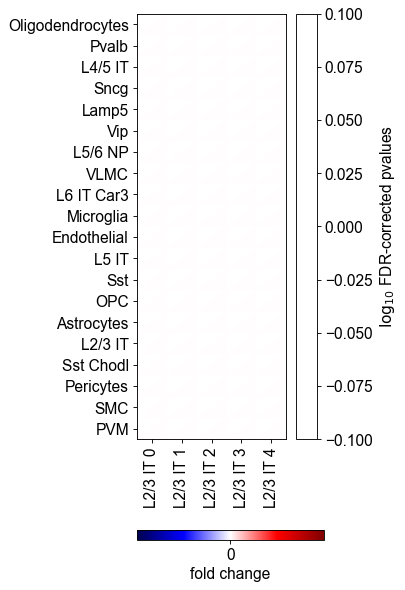

In [435]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=14,
    panel_width=3,
    pvalues_cmap=colors.ListedColormap(sns.color_palette("Greys", n_colors=300)[0]),
    linspace=(0.0, 0.0, 1)
)

# Chip Cytometry - colon

In [20]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_path=dir_data + '/busch/',
    data_origin='jarosch',
    radius=80,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata


  0%|          | 0/2 [00:00<?, ?it/s]

collecting image-wise celldata
adding graph-level covariates


100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

Loaded 2 images with complete data from 1 patients over 11321 cells with 19 cell features and 12 distinct celltypes.
Mean of mean node degree per images across images: 18.522793

 Celldata metadata: {'lateral_resolution': 0.5, 'fn': 'raw_inflamed_colon_1.h5ad', 'image_col': 'Annotation', 'pos_cols': ['X', 'Y'], 'cluster_col': 'celltype_Level_2', 'cluster_col_preprocessed': 'celltype_Level_2_preprocessed', 'patient_col': None}


100%|██████████| 2/2 [00:07<00:00,  3.69s/it]


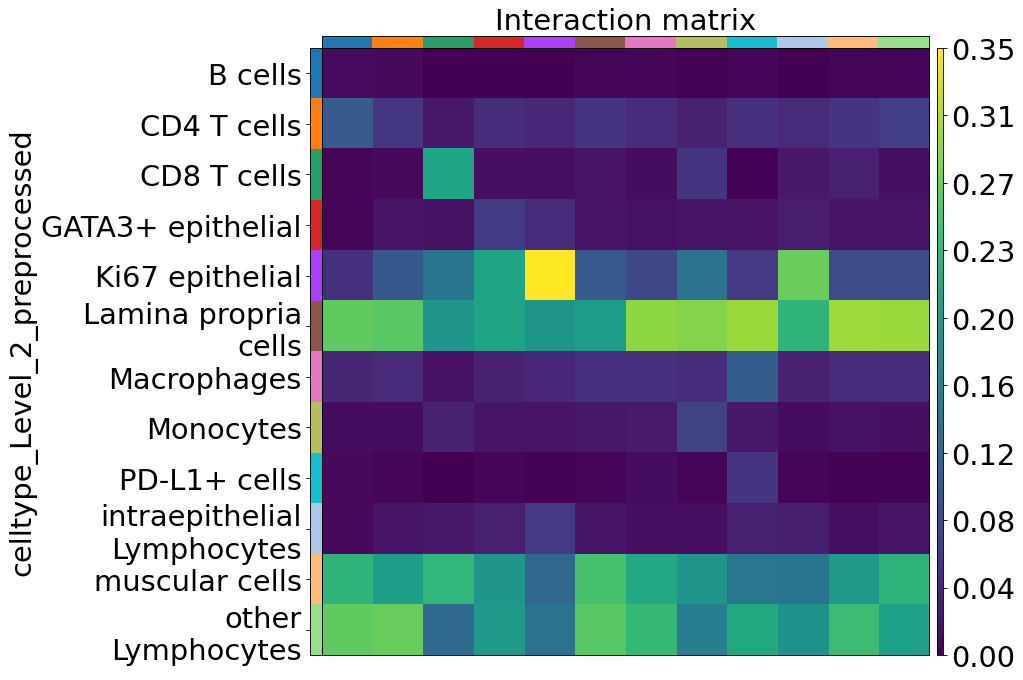

In [22]:
interpreter.data.celldata_interaction_matrix(
    figsize=(8,8),
    fontsize=26
)

100%|██████████| 2/2 [00:02<00:00,  1.07s/it]
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


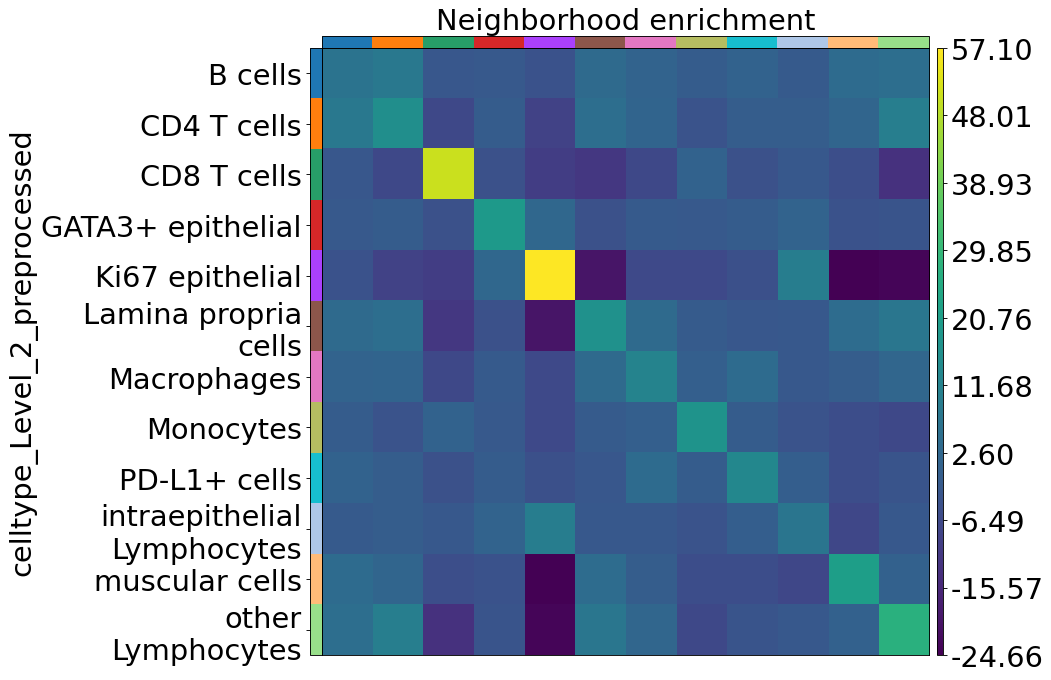

In [23]:
interpreter.data.celldata_nhood_enrichment(
    figsize=(8,8),
    fontsize=26
)

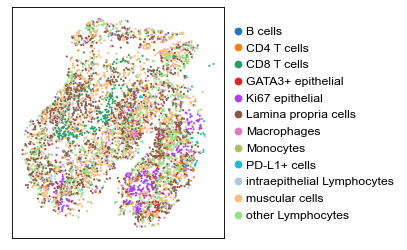

In [533]:
interpreter.data.spatial(
    image_key= "Area_1",
    fontsize=12,
    copy=False,
    panel_width=5,
    panel_height=5
)

n cells:  234
CD8 T cells 0    74
CD8 T cells 1    58
CD8 T cells 2    41
CD8 T cells 3    37
CD8 T cells 4    24
Name: CD8 T cells_substates, dtype: int64


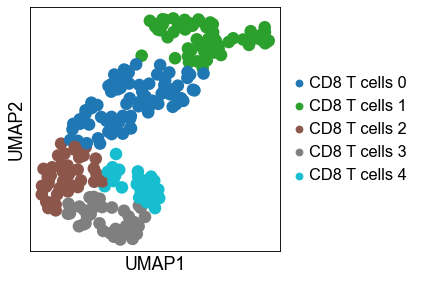

In [695]:
adata = interpreter.data.umap(
    image_key= "Area_1",
    target_cell_type='CD8 T cells',
    n_neighbors=22,
    n_pcs=None,
    fontsize=16,
    panel_width=4,
    panel_height=4,
    palette='tab10'
)

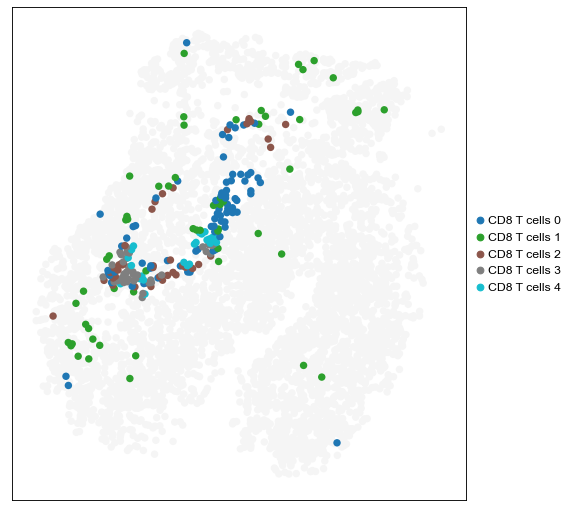

In [698]:
interpreter.data.spatial_substates(
    adata,
    image_key= "Area_1",
    target_cell_type='CD8 T cells',
    panel_width=7,
    panel_height=7,
    fontsize=12,
    spot_size=50
)

In [536]:
filter_titles = [
    'B cells',
    'CD4 T cells',
    'CD8 T cells',
    'GATA3+ epithelial',
    'Ki67 epithelial',
    'Lamina propria cells',
    'Macrophages',
    'Monocytes',
    'intraepithelial Lymphocytes',
    'muscular cells',
    'other Lymphocytes'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key='Area_1',
    target_cell_type='CD8 T cells',
    clip_pvalues=-5,
    n_neighbors=22,
    n_pcs=None,
    filter_titles=filter_titles
)

100%|██████████| 16/16 [00:04<00:00,  3.97it/s]

n cells:  234
CD8 T cells 0    74
CD8 T cells 1    58
CD8 T cells 2    41
CD8 T cells 3    37
CD8 T cells 4    24
Name: CD8 T cells_substates, dtype: int64


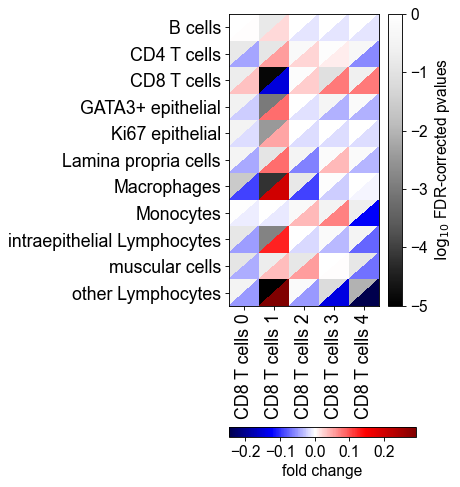

In [540]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=14,
    pad=0.25,
    panel_width=3,
    panel_height=8,
)

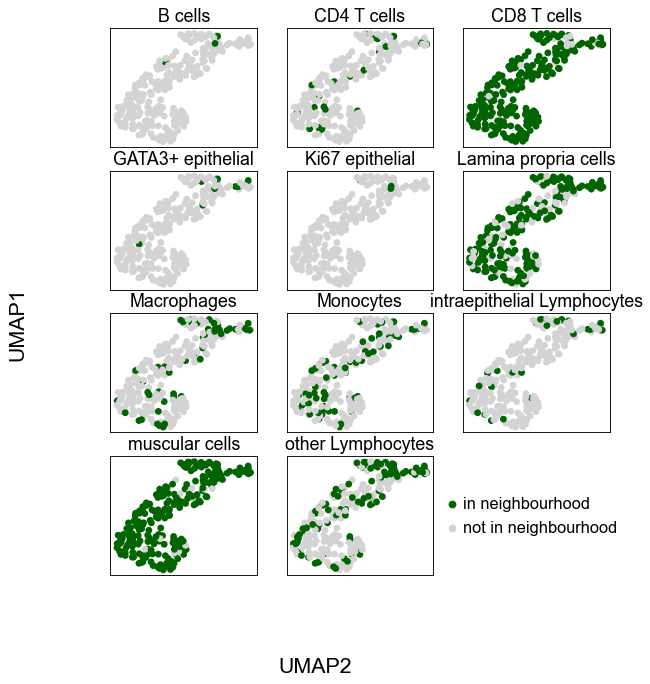

In [539]:
for i, x in enumerate(filter_titles):
    adata.uns[f"source type {x}_colors"] = ['darkgreen', 'lightgrey']
sc.set_figure_params(scanpy=True, fontsize=16)
plt.ioff()
fig, axs = plt.subplots(
    nrows=4, ncols=3, figsize=(8,9), )
fig.supxlabel("UMAP2")
fig.supylabel("UMAP1")
N = len(filter_titles)
#ax = trim_axs(ax, 25)
axs = axs.flat
for ax in axs[N:]:
    ax.remove()
ax = axs[:N]

for i, x in enumerate(filter_titles[:-1]):
    sc.pl.umap(
        adata,
        color=f"source type {x}",
        title=x,
        show=False,
        size=150,
        legend_loc='None',
        ax=ax[i]
    )
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
sc.pl.umap(
    adata,
    color=f"source type {filter_titles[-1]}",
    title=filter_titles[-1],
    show=False,
    size=150,
    ax=ax[N-1]
)
ax[N-1].set_xlabel('')
ax[N-1].set_ylabel('')
# Save, show and return figure.
#plt.tight_layout()
plt.show()

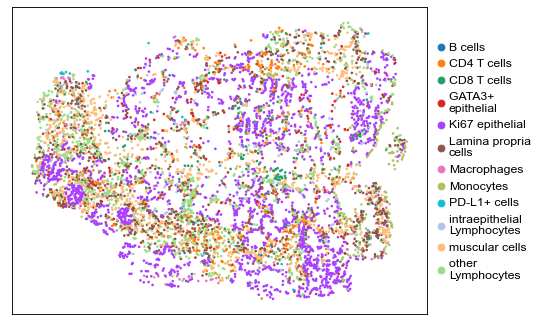

In [304]:
interpreter.data.spatial(
    image_key= "Area_2",
    fontsize=12,
    copy=False
)

n cells:  1076
muscular cells 0    293
muscular cells 1    250
muscular cells 2    249
muscular cells 3    160
muscular cells 4    124
Name: muscular cells_substates, dtype: int64


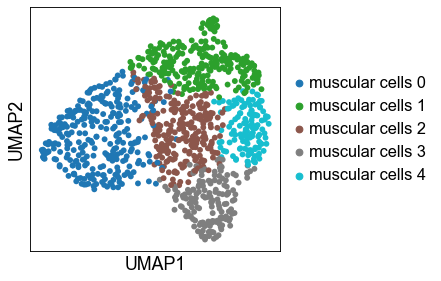

In [337]:
adata = interpreter.data.umap(
    image_key= "Area_2",
    target_cell_type='muscular cells',
    n_neighbors=80,
    n_pcs=None,
    fontsize=16,
    panel_width=4,
    panel_height=4,
    palette='tab10'
)

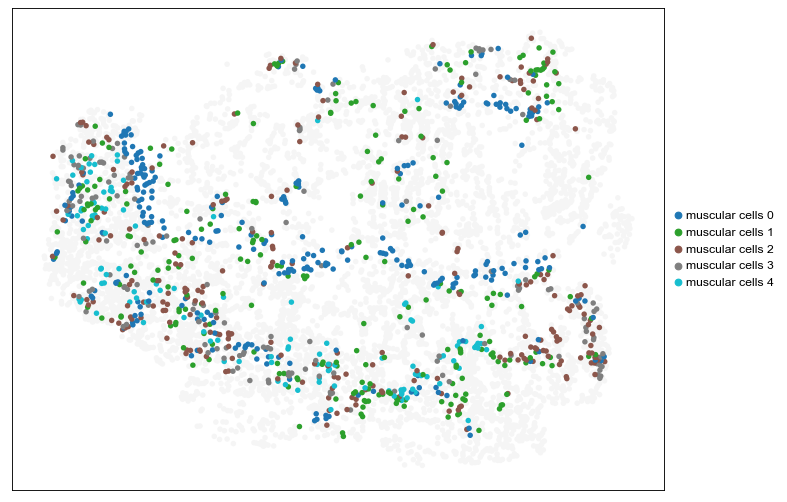

In [339]:
interpreter.data.spatial_substates(
    adata,
    image_key= "Area_2",
    target_cell_type='muscular cells',
    panel_width=10,
    panel_height=10,
    fontsize=12,
)

In [343]:
filter_titles = [
    #'B cells',
    'CD4 T cells',
    'CD8 T cells',
    'GATA3+ \nepithelial',
    'Ki67 epithelial',
    'Lamina propria \ncells',
    'Macrophages',
    'Monocytes',
    'intraepithelial \nLymphocytes',
    'muscular cells',
    'other \nLymphocytes'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key='Area_2',
    target_cell_type='muscular cells',
    clip_pvalues=-5,
    n_neighbors=80,
    n_pcs=None,
    #filter_titles=filter_titles
)

100%|██████████| 16/16 [00:07<00:00,  2.19it/s]

n cells:  1076
muscular cells 0    293
muscular cells 1    250
muscular cells 2    249
muscular cells 3    160
muscular cells 4    124
Name: muscular cells_substates, dtype: int64


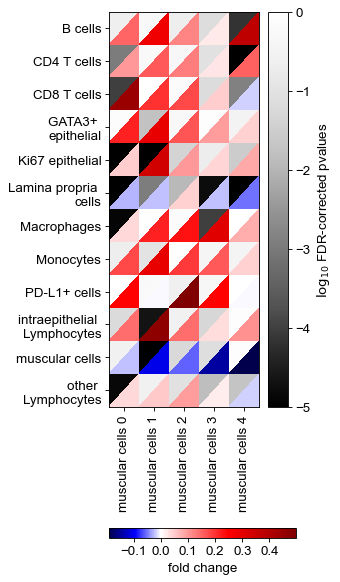

In [345]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=12,
    pad=0.2,
    panel_width=3,
    panel_height=10,
    #linspace=(-0.10, 0.7, 3)
)

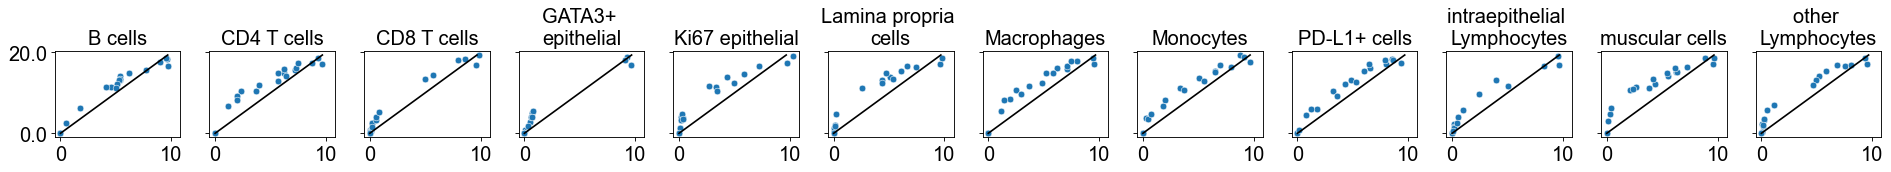

In [67]:
interpreter.data.noise_structure(panel_height=2.5)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


n cells: 11321


  0%|          | 0/1000 [00:00<?, ?permutation/s]

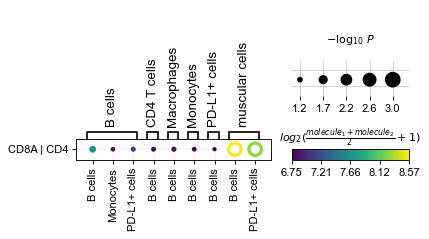

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [68]:
hgnc_names = [
    'CD14', 
    'MS4A1', 
    'IL2RA', 
    'CD3G', 
    'CD4', 
    'PTPRC',
    'PTPRC',
    'PTPRC',
    'CD68', 
    'CD8A', 
    'KRT5', # 'KRT1', 'KRT14'
    'FOXP3', 
    'GATA3', 
    'MKI67', 
    'Nuclei',
    'PDCD1', 
    'CD274', 
    'SMN1', 
    'VIM'
]
adata = interpreter.data.ligrec(
    hgnc_names=hgnc_names,
    seed=10,
    fontsize=12,
    width=2.
)

100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


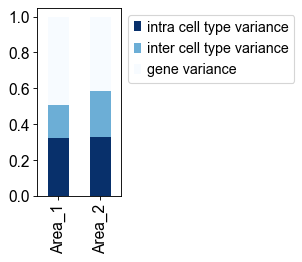

In [76]:
var_decomp = interpreter.data.compute_variance_decomposition()
interpreter.data.variance_decomposition(
    var_decomp, 
    panel_width=4,
    multiindex=False
)

# MIBI TOF - cancer

In [129]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='hartmann',
    data_path=dir_data + 'hartmann/',
    radius=35,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata


/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a futu

/mnt/home/icb/anna.schaar/git/ncem/ncem/data.py:1469: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  tissue_meta_data = read_excel(self.data_path + "scMEP_sample_description.xlsx", usecols=usecols)
  0%|          | 0/58 [00:00<?, ?it/s]Creating graph using `generic` coordinates and `None` transform
Adding `adata.obsp['adjacency_matrix_connectivities']`
       `adata.obsp['adjacency_matrix_distances']`
       `adata.uns['adjacency_matrix_neighbors']`
Finish (0:00:00)
Creating graph using `generic` coordinates and `None` transform
Adding `adata.obsp['adjacency_matrix_connectivities']`
       `adata.obsp['adjacency_matrix_distances']`
       `adata.uns['adjacency_matrix_neighbors']`
Finish (0:00:00)
Creating graph using `generic` coordinates and `None` transform
Adding `adata.obsp['adjacency_matrix_connectiv

       `adata.obsp['adjacency_matrix_distances']`
       `adata.uns['adjacency_matrix_neighbors']`
Finish (0:00:00)
Creating graph using `generic` coordinates and `None` transform
Adding `adata.obsp['adjacency_matrix_connectivities']`
       `adata.obsp['adjacency_matrix_distances']`
       `adata.uns['adjacency_matrix_neighbors']`
Finish (0:00:00)
Creating graph using `generic` coordinates and `None` transform
Adding `adata.obsp['adjacency_matrix_connectivities']`
       `adata.obsp['adjacency_matrix_distances']`
       `adata.uns['adjacency_matrix_neighbors']`
Finish (0:00:00)
 60%|██████    | 35/58 [00:00<00:00, 82.60it/s]Creating graph using `generic` coordinates and `None` transform
Adding `adata.obsp['adjacency_matrix_connectivities']`
       `adata.obsp['adjacency_matrix_distances']`
       `adata.uns['adjacency_matrix_neighbors']`
Finish (0:00:00)
Creating graph using `generic` coordinates and `None` transform
Adding `adata.obsp['adjacency_matrix_connectivities']`
       `adata

Loaded 58 images with complete data from 4 patients over 63734 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416425

 Celldata metadata: {'lateral_resolution': 0.390625, 'fn': ['scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv', 'scMEP_sample_description.xlsx'], 'image_col': 'point', 'pos_cols': ['center_colcoord', 'center_rowcoord'], 'cluster_col': 'Cluster', 'cluster_col_preprocessed': 'Cluster_preprocessed', 'patient_col': 'donor'}


  0%|          | 0/58 [00:00<?, ?it/s]/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/squidpy/gr/_nhood.py:180: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)
100%|██████████| 58/58 [00:03<00:00, 14.59it/s]
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


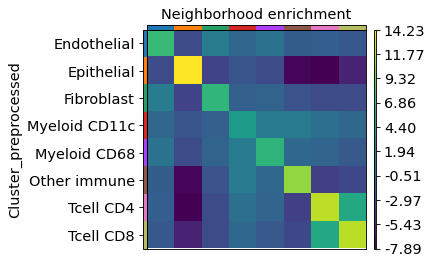

In [39]:
interpreter.data.celldata_nhood_enrichment(
    figsize=(3,3),
    fontsize=13
)

  0%|          | 0/58 [00:00<?, ?it/s]/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/networkx/linalg/attrmatrix.py:302: RuntimeWarning: invalid value encountered in true_divide
  M /= M.sum(axis=1).reshape((N, 1))
100%|██████████| 58/58 [00:03<00:00, 18.63it/s]


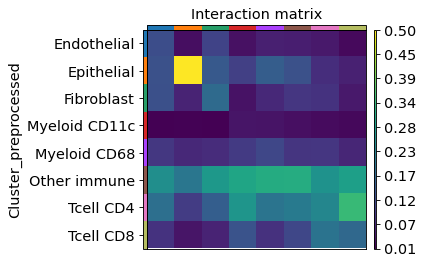

In [40]:
interpreter.data.celldata_interaction_matrix(
    figsize=(3,3),
    fontsize=13
)

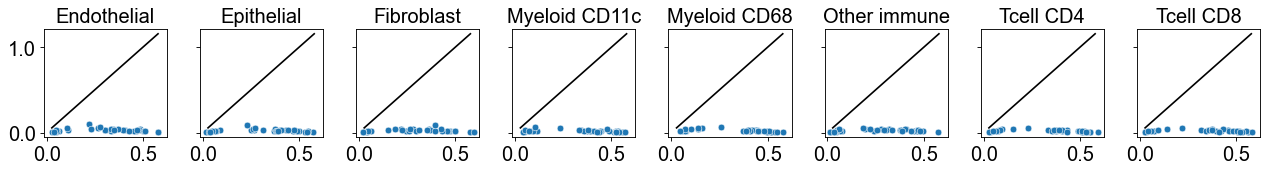

In [100]:
interpreter.data.noise_structure(panel_height=2.5)

n cells: 25493


  0%|          | 0/1000 [00:00<?, ?permutation/s]

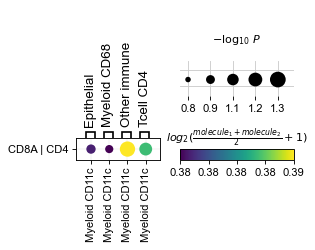

In [101]:
hgnc_names = [
    'H3-4', 
    'VIM', 
    'SMN1', 
    'SLC3A2', 
    'NFE2L2', 
    'CD4', 
    'CD14', 
    'PTPRC', 
    'PDCD1',
    'PECAM1', 
    'SDHA', 
    'MKI67', 
    'CS', 
    'RPS6', 
    'ITGAX', 
    'CD68', 
    'CD36', 
    'ATP5F1A',
    'CD247', 
    'ENTPD1', 
    'VDAC1', 
    'G6PD', 
    'XBP1', 
    'PKM', 
    'SLC1A5', 
    'SLC2A1', 
    'CD8A',
    'B3GAT1', 
    'LDHA', 
    'IDH2', 
    'HK1', 
    'CDH1', 
    'CPT1A', 
    'CKM', 
    'ATP1A1',
    'HIF1A'
]
adata = interpreter.data.ligrec(
    hgnc_names=hgnc_names,
    fraction=0.40,
    fontsize=12,
    width=2.,
)

100%|██████████| 58/58 [00:35<00:00,  1.63it/s]


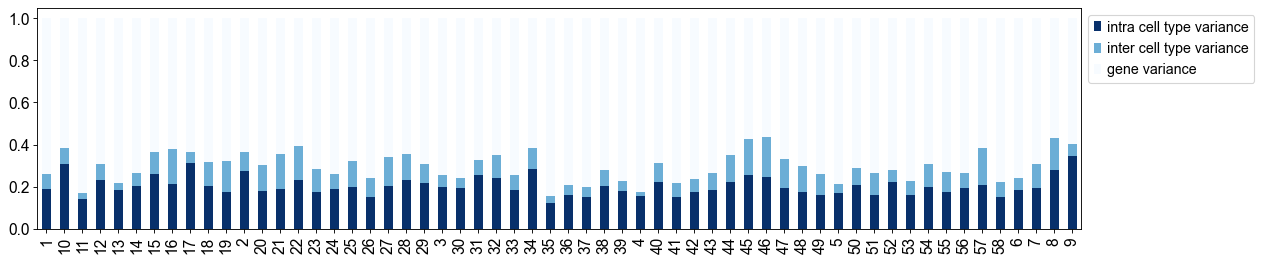

In [99]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='other')
interpreter.data.variance_decomposition(
    var_decomp, 
    #panel_width=4,
    #multiindex=False
)

In [130]:
sc.pp.normalize_total(interpreter.data.celldata)
sc.pp.normalize_total(interpreter.data.img_celldata['1'])
sc.pp.normalize_total(interpreter.data.img_celldata['5'])
sc.pp.normalize_total(interpreter.data.img_celldata['8'])
sc.pp.normalize_total(interpreter.data.img_celldata['16'])

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [131]:
adata = interpreter.data.celldata[interpreter.data.celldata.obs['point'].isin([1, 5, 8, 16])].copy()

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [132]:
adata_CD8T = adata[adata.obs['Cluster_preprocessed'] == 'Tcell CD8'].copy()

In [133]:
sc.settings.verbosity = 3  
sc.pp.neighbors(adata_CD8T, n_neighbors=60, n_pcs=None)
sc.tl.louvain(adata_CD8T)
sc.tl.umap(adata_CD8T)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [53]:
img_keys = [1, 5, 8, 16]

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view

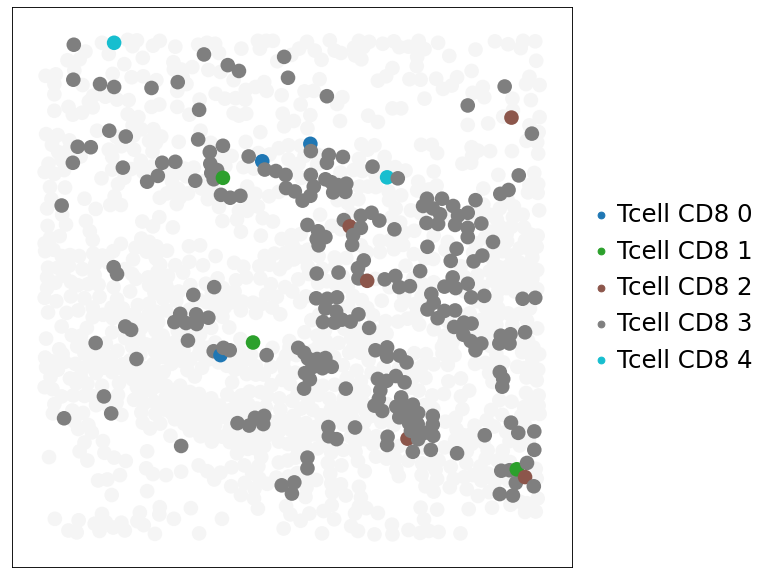

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view

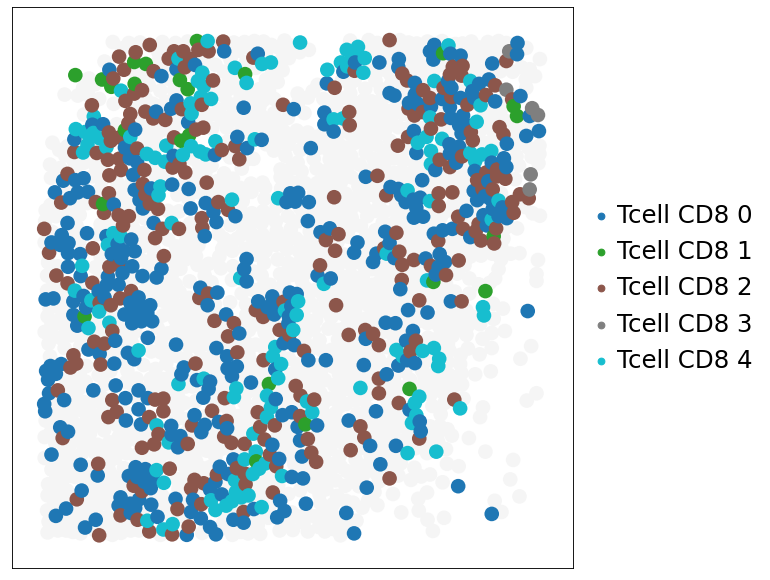

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view

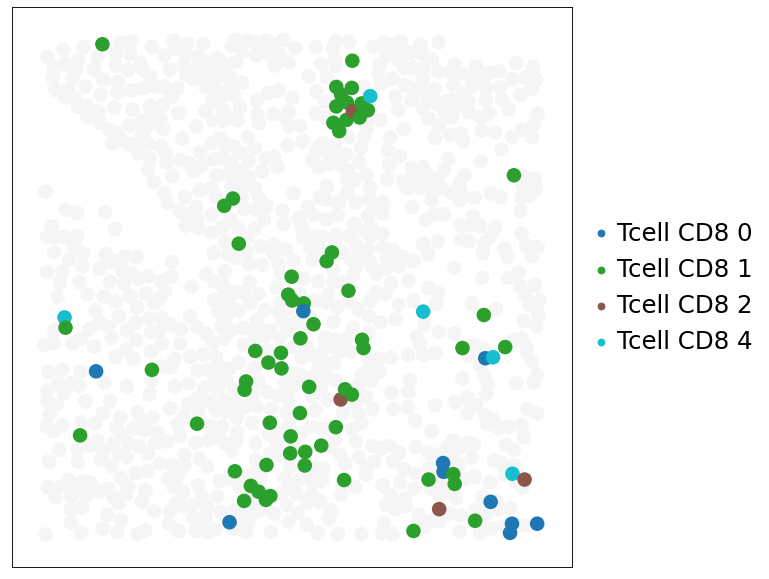

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view

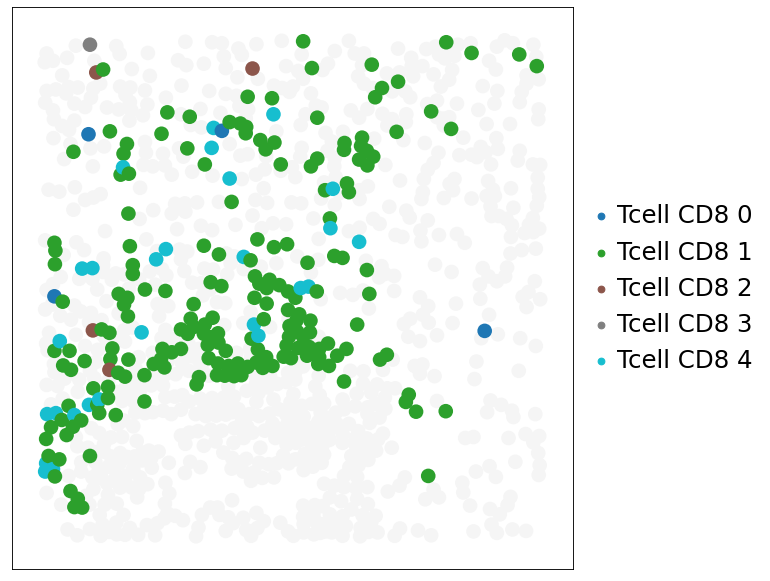

In [57]:
for k in img_keys:
    interpreter.data.spatial_substates(
        adata_CD8T[adata_CD8T.obs['point'] == k],
        image_key= str(k),
        target_cell_type='Tcell CD8',
        panel_width=10,
        spot_size=30,
        panel_height=10,
        fontsize=24,
        palette=['#1f77b4', '#2ca02c', '#8c564b', '#7f7f7f', '#17becf']
    )

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view

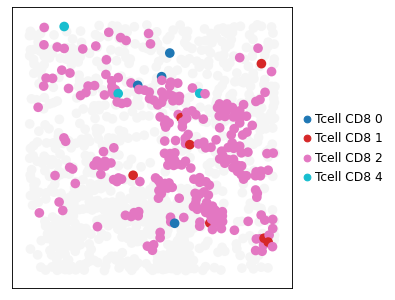

In [60]:
interpreter.data.spatial_substates(
    adata_CD8T[adata_CD8T.obs['point'] == 1],
    image_key= "16",
    target_cell_type='Tcell CD8',
    panel_width=5,
    panel_height=5,
    fontsize=12,
)

In [134]:
adata_CD8T

AnnData object with n_obs × n_vars = 1329 × 36
    obs: 'point', 'cell_id', 'donor', 'Cluster', 'Cluster_preprocessed', 'louvain'
    uns: 'metadata', 'img_keys', 'img_to_patient_dict', 'node_type_names', 'graph_covariates', 'neighbors', 'louvain', 'umap'
    obsm: 'spatial', 'node_types', 'X_umap'
    obsp: 'distances', 'connectivities'

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view

[<AxesSubplot:xlabel='spatial1', ylabel='spatial2'>]

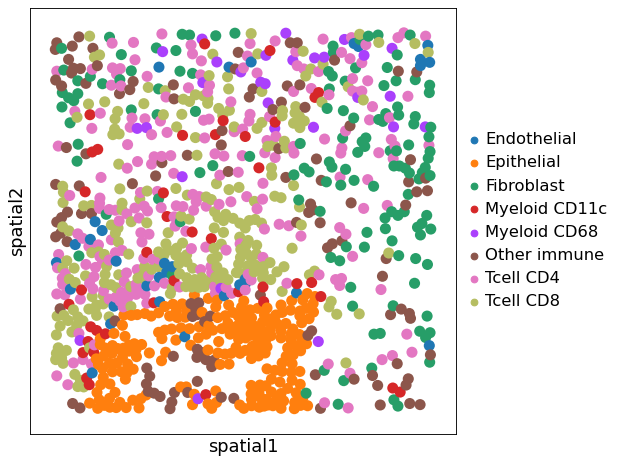

In [155]:
fig, ax = plt.subplots(
                nrows=1, ncols=1, figsize=(7, 7), )
sc.pl.spatial(
    interpreter.data.celldata[interpreter.data.celldata.obs['point'] == 16],
    color='Cluster_preprocessed',
    spot_size=30,
    title='',
    ax=ax,
    show=False
)

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (

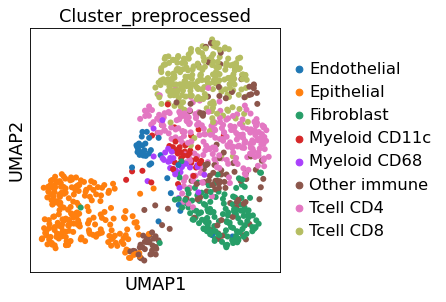

In [158]:
sc.settings.verbosity = 3  
temp_adata = interpreter.data.celldata[interpreter.data.celldata.obs['point'] == 16].copy()
sc.pp.neighbors(temp_adata, n_neighbors=60, n_pcs=None)
sc.tl.louvain(temp_adata)
sc.tl.umap(temp_adata)
sc.pl.umap(
    temp_adata,
    color='Cluster_preprocessed'
)

In [160]:
temp_adata.uns['Cluster_preprocessed_colors']

['#1f77b4',
 '#ff7f0e',
 '#279e68',
 '#d62728',
 '#aa40fc',
 '#8c564b',
 '#e377c2',
 '#b5bd61']

In [188]:
interpreter.data.celldata[interpreter.data.celldata.obs['point'].isin([1,5,8,16])]

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 5506 × 36
    obs: 'point', 'cell_id', 'donor', 'Cluster', 'Cluster_preprocessed'
    uns: 'metadata', 'img_keys', 'img_to_patient_dict', 'node_type_names', 'graph_covariates'
    obsm: 'spatial', 'node_types'

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view

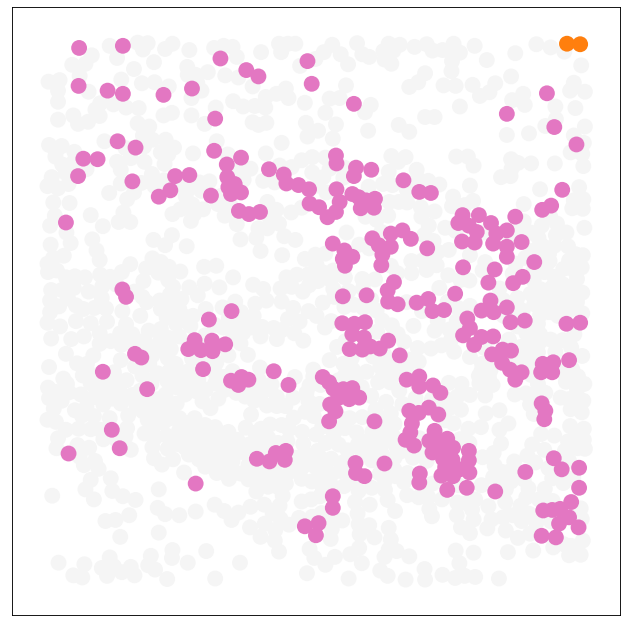

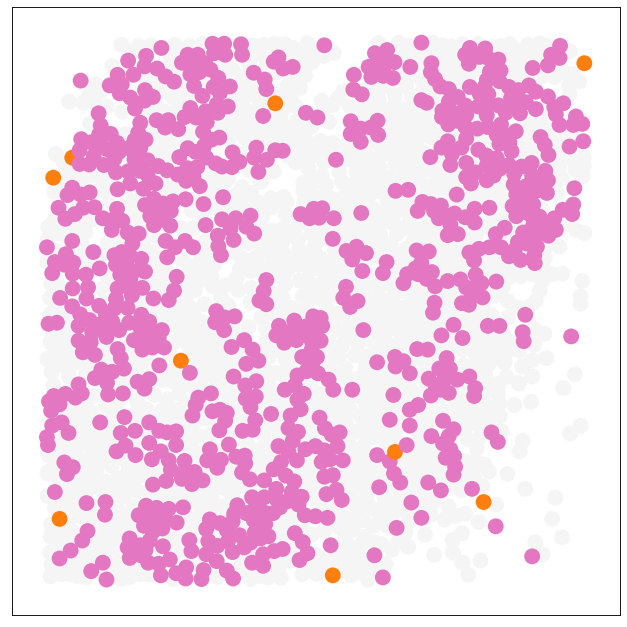

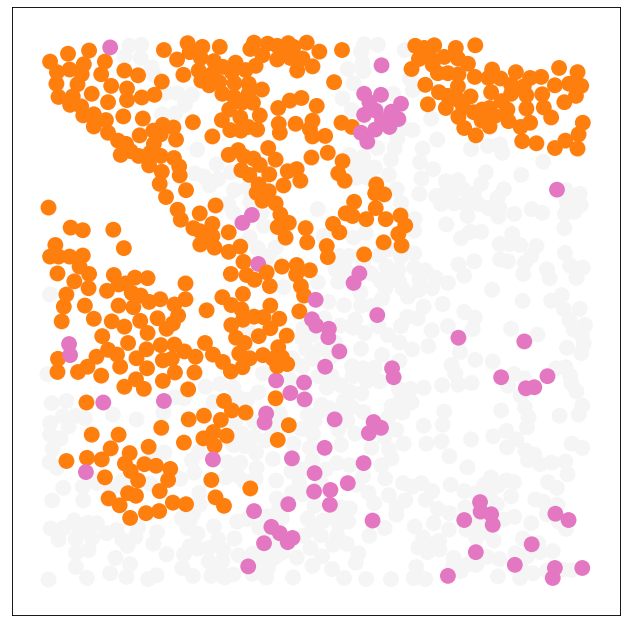

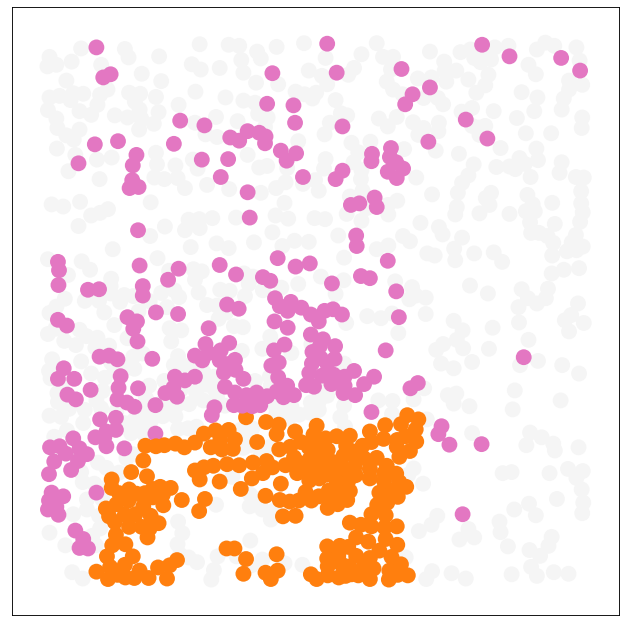

In [161]:
for k in img_keys:
    temp_adata = interpreter.data.celldata[interpreter.data.celldata.obs['point'] == k].copy()
    fig, ax = plt.subplots(
                nrows=1, ncols=1, figsize=(10, 10), )
    sc.pl.spatial(
        temp_adata[temp_adata.obs['Cluster_preprocessed'] != 'Tcell CD8'],
        spot_size=30,
        
        ax=ax,
        show=False,
        na_color='whitesmoke',
        title=''
    )
    sc.pl.spatial(
        temp_adata[temp_adata.obs['Cluster_preprocessed'].isin(['Tcell CD8', 'Epithelial'])],
        color='Cluster_preprocessed',
        spot_size=30,
        ax=ax,
        show=False,
        legend_loc='left',
        title='',
        palette={'Epithelial': '#ff7f0e', 'Tcell CD8': '#e377c2'}
    )
    ax.invert_yaxis()
    ax.set_xlabel('')
    ax.set_ylabel('')

In [186]:
adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key=['1', '5', '8', '16'],
    target_cell_type='Tcell CD8',
    clip_pvalues=-5,
    n_neighbors=60,
    n_pcs=None
)

 90%|████████▉ | 111/124 [00:01<00:00, 73.72it/s]/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
   

n cells:  1329
Tcell CD8 0    359
Tcell CD8 1    307
Tcell CD8 2    254
Tcell CD8 3    250
Tcell CD8 4    159
Name: Tcell CD8_substates, dtype: int64


<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

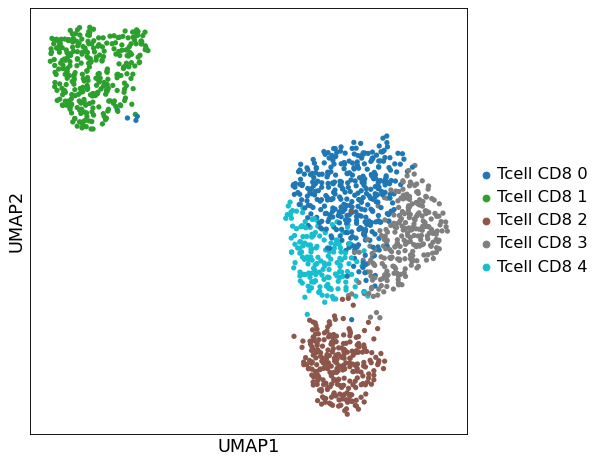

In [187]:
fig, ax = plt.subplots(
                nrows=1, ncols=1, figsize=(7, 7), )
sc.pl.umap(adata, color='Tcell CD8_substates', palette='tab10', ax=ax, show=False, title='')

In [143]:
filter_titles = list(np.unique(interpreter.data.celldata.obs['Cluster_preprocessed']))

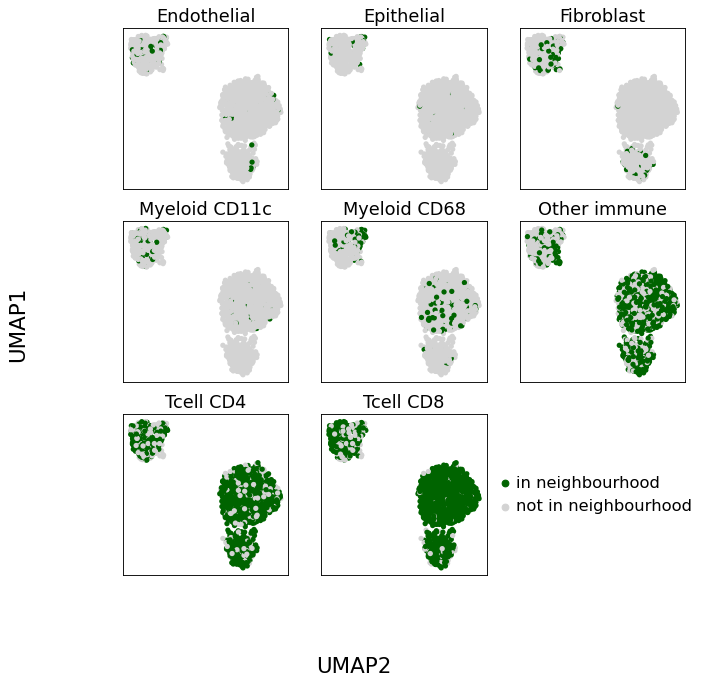

In [185]:
for i, x in enumerate(filter_titles):
    adata.uns[f"source type {x}_colors"] = ['darkgreen', 'lightgrey']
sc.set_figure_params(scanpy=True, fontsize=16)
plt.ioff()
fig, axs = plt.subplots(
    nrows=3, ncols=3, figsize=(9, 9), )
fig.supxlabel("UMAP2")
fig.supylabel("UMAP1")
N = len(filter_titles)
#ax = trim_axs(ax, 25)
axs = axs.flat
for ax in axs[N:]:
    ax.remove()
ax = axs[:N]

for i, x in enumerate(filter_titles[:-1]):
    sc.pl.umap(
        adata,
        color=f"source type {x}",
        title=x,
        show=False,
        #size=200,
        legend_loc='None',
        ax=ax[i]
    )
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
sc.pl.umap(
    adata,
    color=f"source type {filter_titles[-1]}",
    title=filter_titles[-1],
    show=False,
    #size=50,
    ax=ax[N-1]
)
ax[N-1].set_xlabel('')
ax[N-1].set_ylabel('')
# Save, show and return figure.
#plt.tight_layout()
plt.show()


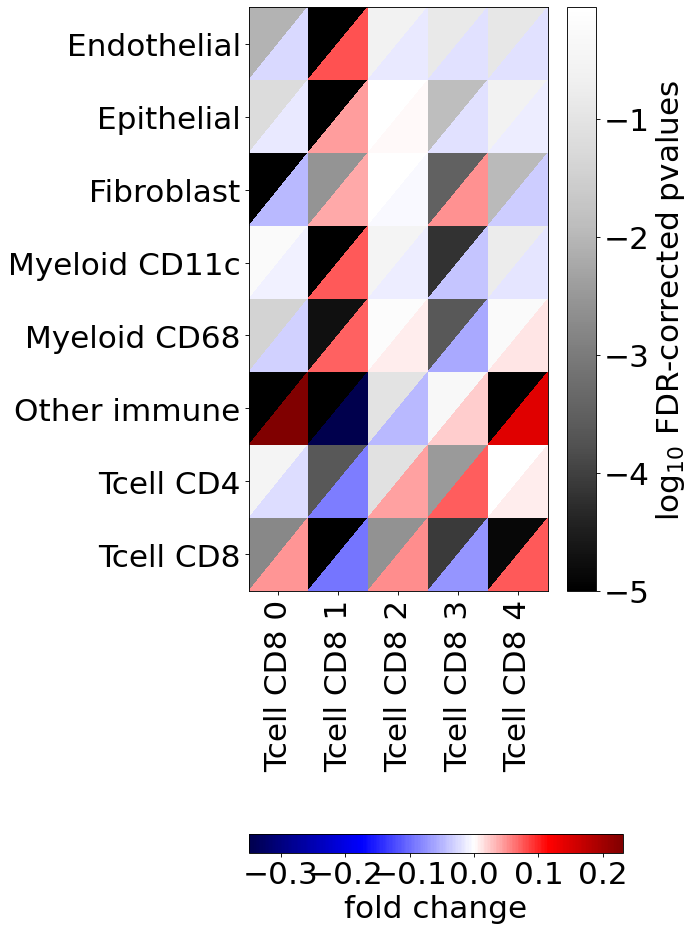

In [128]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=28,
    panel_width=6,
    panel_height=16,
    pad=0.25,
)

# MELC - tonsils data

In [31]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='pascualreguant',
    data_path=dir_data + 'pascualreguant/',
    radius=60,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata


/mnt/home/icb/anna.schaar/git/ncem/ncem/data.py:1584: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  nuclei_df = read_excel(self.data_path + metadata["fn"][0])
/mnt/home/icb/anna.schaar/git/ncem/ncem/data.py:1585: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  membranes_df = read_excel(self.data_path + metadata["fn"][1])
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 1/1 [00:00<00:00, 12.75it/s]

collecting image-wise celldata
adding graph-level covariates
Loaded 1 images with complete data from 1 patients over 6991 cells with 51 cell features and 9 distinct celltypes.
Mean of mean node degree per images across images: 19.083107

 Celldata metadata: {'lateral_resolution': 0.325, 'fn': ['TONSIL_MFI_nuclei_data_table.xlsx', 'TONSIL_MFI_membranes_data_table.xlsx'], 'image_col': 'img_keys', 'pos_cols': ['Location_Center_X', 'Location_Center_Y'], 'cluster_col': 'cell_class', 'cluster_col_preprocessed': 'cell_class_preprocessed', 'patient_col': None}


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


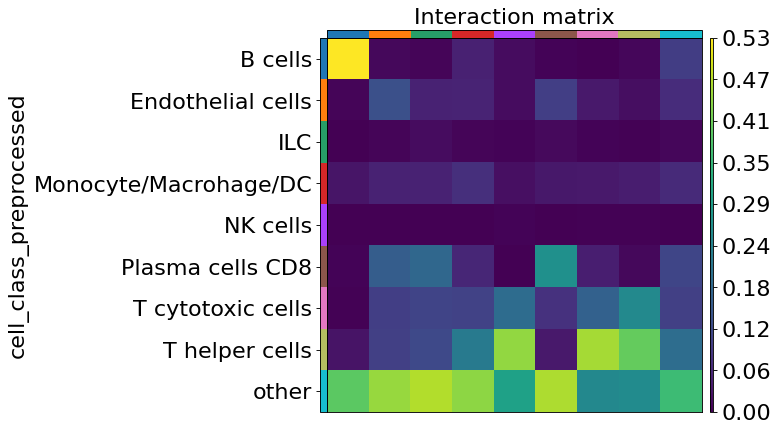

In [32]:
interpreter.data.celldata_interaction_matrix(
    figsize=(5,5),
    fontsize=20
)

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


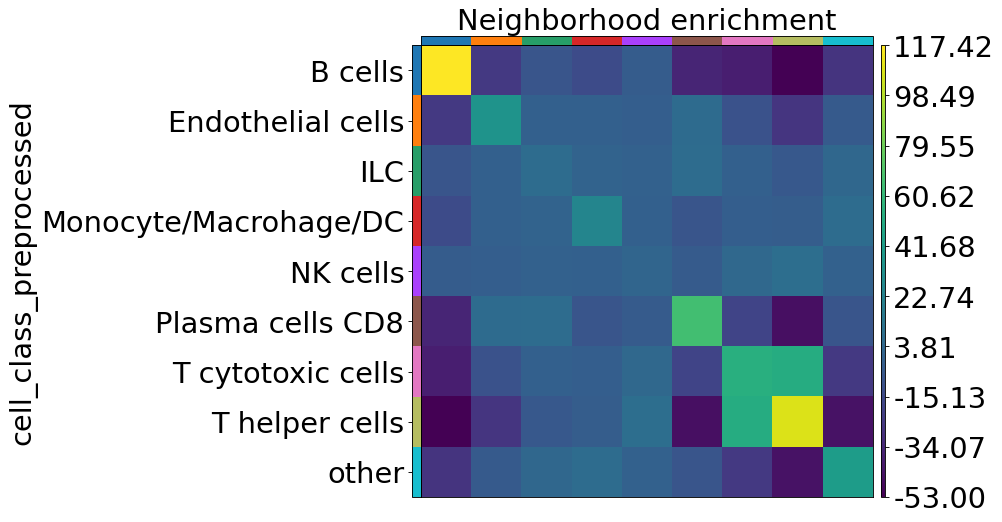

In [33]:
interpreter.data.celldata_nhood_enrichment(
    figsize=(6,6),
    fontsize=26
)

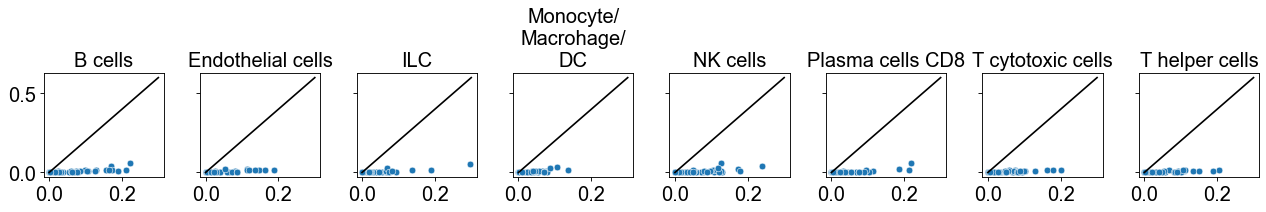

In [113]:
interpreter.data.noise_structure(
    undefined_type='other',
    min_x=0.0, max_x=0.3,
    panel_height=3
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


n cells: 4470


  0%|          | 0/1000 [00:00<?, ?permutation/s]

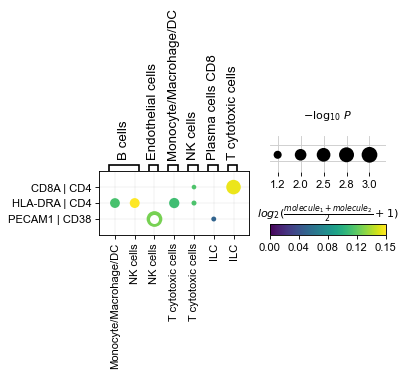

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [118]:
hgnc_names = [
    'BCL6', 
    'FOXP3', 
    'IKZF2', 
    'IRF4', 
    'MKI67', 
    'PAX5', 
    'CCR6', 
    'ITGAE',
    'ITGAX', 
    'IL3RA', 
    'IL7R', 
    'SDC1', 
    'CD14', 
    'THBD', 
    'FCGR3A', 
    'KLRB1',
    'CD19', 
    'MS4A1', 
    'CR2', 
    'FCER2', 
    'CD247', 
    'PECAM1', 
    'CD34', 
    'CD38', 
    'CD4',
    'PTPRC', 
    'PTPRC', 
    'PTPRC', 
    'ITGA1', 
    'NCAM1', 
    'CD69', 
    'CD7', 
    'CD8A',
    'KLRD1', 
    'CXCR3', 
    'FCER1A', 
    'GZMA', 
    'HLA-DRA', 
    'ICOS', 
    'CD79A', 
    'IGHG1',
    'IGHM', 
    'CD207', 
    'NCR2', 
    'TNFSF11', 
    'SMN1', 
    'TCRVa72', ## 
    'TRG', 
    'VCAM1',
    'VIM', 
    'KIT'
]
adata = interpreter.data.ligrec(
    hgnc_names=hgnc_names,
    undefined_type='other',
    fontsize=12,
    width=2.,
)

100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


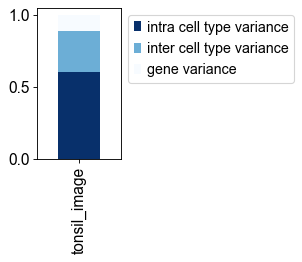

In [246]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='other')
interpreter.data.variance_decomposition(
    var_decomp, 
    panel_width=4,
    #multiindex=False
)

# CODEX - cancer

In [35]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='schuerch',
    data_path=dir_data + 'schuerch/',
    radius=60,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata


/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata


  6%|▋         | 9/140 [00:00<00:01, 82.62it/s]

adding graph-level covariates


100%|██████████| 140/140 [00:02<00:00, 69.90it/s]


Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 21 distinct celltypes.
Mean of mean node degree per images across images: 10.311835

 Celldata metadata: {'lateral_resolution': 0.377442, 'fn': 'CRC_clusters_neighborhoods_markers_NEW.csv', 'image_col': 'File Name', 'pos_cols': ['X:X', 'Y:Y'], 'cluster_col': 'ClusterName', 'cluster_col_preprocessed': 'ClusterName_preprocessed', 'patient_col': 'patients'}


 78%|███████▊  | 109/140 [00:24<00:06,  4.57it/s]/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/networkx/linalg/attrmatrix.py:302: RuntimeWarning: invalid value encountered in true_divide
  M /= M.sum(axis=1).reshape((N, 1))
100%|██████████| 140/140 [00:28<00:00,  4.92it/s]
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


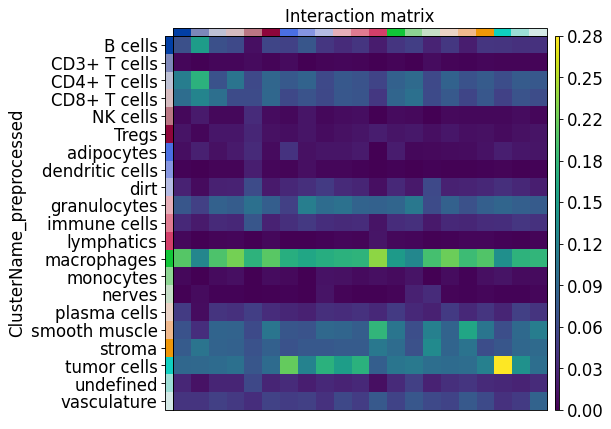

In [36]:
interpreter.data.celldata_interaction_matrix(
    figsize=(5,5),
    fontsize=15
)

  1%|          | 1/140 [00:01<03:46,  1.63s/it]/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/squidpy/gr/_nhood.py:180: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)
  2%|▏         | 3/140 [00:05<03:57,  1.73s/it]/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/squidpy/gr/_nhood.py:180: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)
  4%|▍         | 6/140 [00:05<01:13,  1.83it/s]/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/squidpy/gr/_nhood.py:180: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)
  6%|▋         | 9/140 [00:07<01:08,  1.93it/s]/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/squidpy/gr/_nhood.py:180: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis

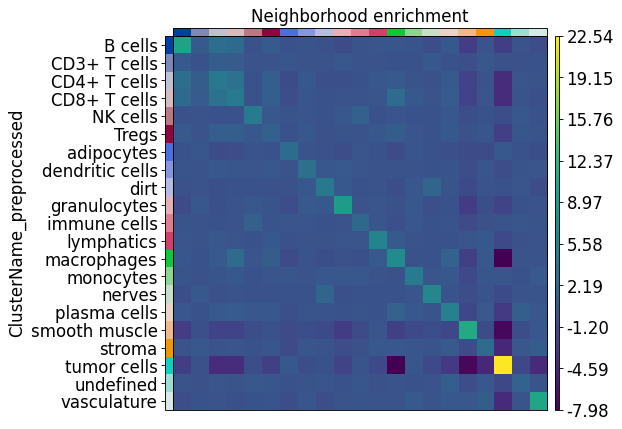

In [37]:
interpreter.data.celldata_nhood_enrichment(
    figsize=(5,5),
    fontsize=15
)

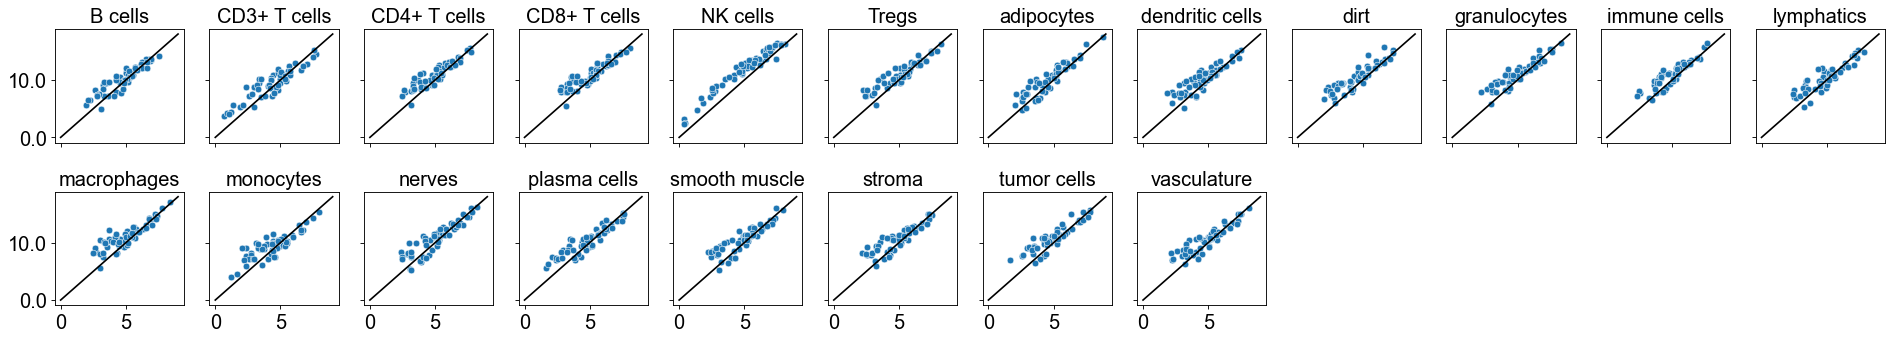

In [128]:
interpreter.data.noise_structure(
    undefined_type='undefined',
    min_x=0.0, max_x=9., panel_height=2.3
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


n cells: 25226


  0%|          | 0/1000 [00:00<?, ?permutation/s]

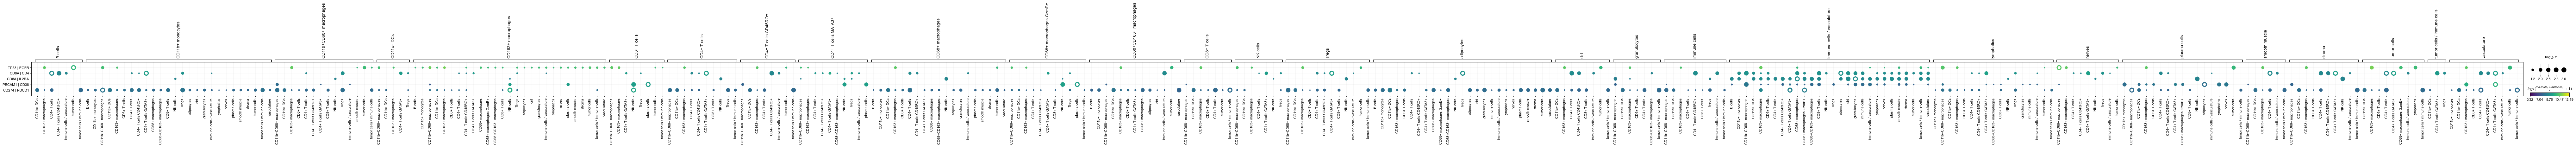

In [249]:
hgnc_names = [
    'CD44', 
    'FOXP3', 
    'CD8A', 'TP53', 
    'GATA3', 
    'PTPRC', 
    'TBX21', 
    'CTNNB1',
    'HLA-DR', 
    'CD274', 
    'MKI67', 
    'PTPRC', 
    'CD4', 
    'CR2', 
    'MUC1', 
    'TNFRSF8',
    'CD2', 
    'VIM', 
    'MS4A1', 
    'LAG3', 
    'ATP1A1', 
    'CD5', 
    'IDO1',
    'KRT1', 
    'ITGAM', 
    'NCAM1', 
    'ACTA1', 
    'BCL2', 
    'IL2RA', 
    'ITGAX',
    'PDCD1', 
    'GZMB', 
    'EGFR', 
    'VISTA', 
    'FUT4', 
    'ICOS', 
    'SYP',
    'GFAP', 
    'CD7', 
    'CD247', 
    'CHGA', 
    'CD163', 
    'PTPRC', 
    'CD68',
    'PECAM1', 
    'PDPN', 
    'CD34', 
    'CD38', 
    'SDC1', 
    'HOECHST1:Cyc_1_ch_1', ##
    'CDX2', 
    'COL6A1', 
    'CCR4', 
    'MMP9', 
    'TFRC', 
    'B3GAT1', 
    'MMP12'
]
adata = interpreter.data.ligrec(
    hgnc_names=hgnc_names,
    undefined_type='undefined',
    fraction=0.1,
    fontsize=12,
    width=2.,
)

100%|██████████| 140/140 [02:33<00:00,  1.09s/it]


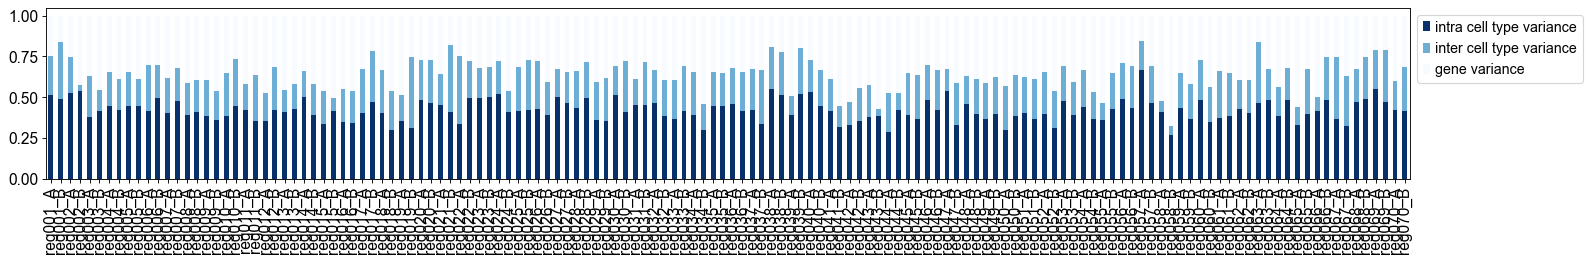

In [250]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='undefined')
interpreter.data.variance_decomposition(
    var_decomp, 
    panel_width=20,
    #multiindex=False
)